1. Preprocessing Routine
Objective: Implement a preprocessing pipeline to clean and standardize data, ensuring that both training and test data are processed the same way.
Implementation: Use tools like StandardScaler for normalization and SimpleImputer for handling missing values. Package this as a pipeline step in sklearn to maintain consistency across different stages.
2. Feature Selection and Dimensionality Reduction
Objective: Prioritize the most relevant features and potentially reduce the feature space for faster training.

Approach:

Permutation Testing: Test different feature subsets by dropping specific columns and evaluating changes in performance. Track changes in the F1 score for each subset to identify impactful features.
Dimensionality Reduction (PCA): Use PCA to further reduce dimensionality by retaining components that account for a significant portion of variance (e.g., 95%). This can accelerate model training by reducing noise and unimportant features.
Feature Importance from PCA: Evaluate which features contribute most to each principal component, based on eigenvalues. Discard features with minimal contributions to maintain a balance between performance and model complexity.

3. Model Training with XGBoost Classifier
Objective: Train the model using the optimized feature set from the previous step.
Pipeline Setup: Create a pipeline that includes the preprocessing, feature selection, and XGBoost model.
Hyperparameter Tuning with K-Fold Grid Search:
Use GridSearchCV to tune hyperparameters such as learning_rate, max_depth, n_estimators, and subsample.
Set scoring='f1' to prioritize the F1 score during optimization.
4. Evaluate the Impact of Feature Selection and Dimensionality Reduction
Objective: Determine whether feature reduction has improved, degraded, or maintained model performance.
Comparison: After finding the optimal hyperparameters, compare F1 scores from models trained with full features versus reduced features (via permutation tests and PCA) to confirm the benefits of feature selection.
5. Latent Space Embedding Projection (Optional)
Objective: Further understand the data structure by projecting it into a latent space for analysis.
Techniques: Use t-SNE, UMAP, or autoencoders to create embeddings that could reveal additional patterns or relationships, potentially informing new feature engineering strategies.
6. Neural Network Exploration (Optional)
Objective: Explore neural networks as an alternative to XGBoost for this task.
Implementation:
Replace XGBoost with a neural network architecture, varying parameters like layer count, activation functions, learning rate, and batch size.
Use GridSearchCV for tuning and evaluation, focusing on the F1 score to match previous results.
Comparison: Evaluate neural network performance relative to XGBoost in terms of F1 score and computational efficiency.


In [1]:
!pip install category-encoders==2.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# next step could be to take the preprocessing from the first notebook to this one

# test_clean_df = pd.read_csv('test_clean_df.csv')
train_clean_df = pd.read_csv('cleaned_dataset.csv')

In [3]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,...,NaN,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,2020.0,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,...,NaN,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,...,NaN,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20870,NaN,NaN,NaN,2020-02-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,OTHER_CARRIERS,OTHER_COUNTIES,NaN,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,NaN,NaN
20871,2020-02-03,22.0,N,2020-02-05,N,0.00,1997.0,2020-02-05,NaN,A I U INSURANCE COMPANY,...,NaN,A I U INSURANCE COMPANY,QUEENS,114,ACCOMMODATION AND FOOD SERVICES,PUSHING OR PULLING,CONTUSION,ANKLE,M,N
20872,2020-02-02,51.0,N,2020-02-05,Y,0.00,1968.0,2020-02-05,2020-02-03,NYC TRANSIT AUTHORITY,...,NaN,NYC TRANSIT AUTHORITY,BRONX,104,TRANSPORTATION AND WAREHOUSING,"STRUCK OR INJURED, NOC",CONTUSION,KNEE,M,N
20873,2020-01-22,55.0,N,2020-02-05,N,0.00,NaN,2020-02-05,NaN,AMERICAN ZURICH INSURANCE CO,...,NaN,AMERICAN ZURICH INSURANCE CO,NEW YORK,070,REAL ESTATE AND RENTAL AND LEASING,"HAND TOOL, UTENSIL; NOT POWERED",LACERATION,HAND,M,N


In [4]:
train_clean_df.columns

Index(['Accident Date', 'Age at Injury', 'Alternative Dispute Resolution',
       'Assembly Date', 'Attorney/Representative', 'Average Weekly Wage',
       'Birth Year', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type',
       'Claim Identifier', 'Claim Injury Type', 'County of Injury',
       'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender',
       'IME-4 Count', 'Industry Code', 'Industry Code Description',
       'Medical Fee Region', 'OIICS Nature of Injury Description',
       'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description',
       'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code',
       'Agreement Reached', 'WCB Decision', 'Number of Dependents',
       'Accident Date_Month', 'Accident Date_Quarter', 'Accident Date_Year',
       'Assembly Date_Month', 'Assembly Date_Quarter', 'Assembly Date_Year',
       'C-2 Date_Month', 'C-2 Date_Quarter', 'C

In [5]:
missing_percentage = (train_clean_df.isnull().sum() / len(train_clean_df)) * 100

print(missing_percentage)

Accident Date                                  3.592814
Age at Injury                                  4.019162
Alternative Dispute Resolution                 2.917365
Assembly Date                                  0.000000
Attorney/Representative                        2.917365
Average Weekly Wage                            7.899401
Birth Year                                    14.740120
C-2 Date                                       5.341317
C-3 Date                                      68.239521
Carrier Name                                   2.917365
Carrier Type                                   2.917365
Claim Identifier                               0.000000
Claim Injury Type                              2.917365
County of Injury                               2.917365
COVID-19 Indicator                             2.917365
District Name                                  2.917365
First Hearing Date                            74.366467
Gender                                         2

In [6]:
# exclude colls definition
exclude_cols = [
    'Zip Code',
    'OIICS Nature of Injury Description',
    'IME-4 Count',
    'First Hearing Date_Year',
    'First Hearing Date_Quarter',
    'First Hearing Date_Month',
    'First Hearing Date',
    'C-3 Date_Year',
    'C-3 Date',
    'C-3 Date_Quarter',
    'C-3 Date_Month',
    'Alternative Dispute Resolution',
    'WCIO Nature of Injury Code',
    'WCIO Nature of Injury Description',
    'Gender',
    'WCIO Cause of Injury Description',
    'Industry Code Description',
    'County of Injury',
    'Carrier Name',
    'Accident Date_Month',	'Accident Date_Quarter',	'Accident Date_Year' ,	'Assembly Date_Month',	'Assembly Date_Quarter'	,'Assembly Date_Year',	'C-2 Date_Month',	'C-2 Date_Quarter',	'C-2 Date_Year'
]

#claim injury identifier before testing, and agreement reached



In [7]:
numerical_features = train_clean_df.select_dtypes(include=np.number).columns
categorical_features = train_clean_df.select_dtypes(exclude=np.number).columns

for feature in numerical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mean())

for feature in categorical_features:
   train_clean_df[feature] = train_clean_df[feature].fillna(train_clean_df[feature].mode()[0])

In [8]:
train_dropped_df = train_clean_df.copy()

columns_to_drop = exclude_cols

train_dropped_df = train_dropped_df.drop(columns=columns_to_drop)



In [9]:
train_clean_df

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,First Hearing Date_Year,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.000000,N,2020-01-01,N,0.000000,1988.000000,2019-12-31,2020-01-27,NEW HAMPSHIRE INSURANCE CO,...,2020.489067,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.000000,N,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,2020.000000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.000000,N,2020-01-01,N,1434.800000,1979.000000,2020-01-01,2020-01-27,INDEMNITY INSURANCE CO OF,...,2020.489067,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-01-08,42.904722,N,2020-01-01,N,451.370352,1975.913192,2020-01-28,2020-01-27,STATE INSURANCE FUND,...,2020.489067,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.000000,N,2020-01-01,N,451.370352,1958.000000,2019-12-31,2020-01-27,STATE INSURANCE FUND,...,2020.489067,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20870,2020-01-08,42.904722,N,2020-02-05,N,451.370352,1975.913192,2020-01-28,2020-01-27,STATE INSURANCE FUND,...,2020.489067,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
20871,2020-02-03,22.000000,N,2020-02-05,N,0.000000,1997.000000,2020-02-05,2020-01-27,A I U INSURANCE COMPANY,...,2020.489067,A I U INSURANCE COMPANY,QUEENS,114,ACCOMMODATION AND FOOD SERVICES,PUSHING OR PULLING,CONTUSION,ANKLE,M,N
20872,2020-02-02,51.000000,N,2020-02-05,Y,0.000000,1968.000000,2020-02-05,2020-02-03,NYC TRANSIT AUTHORITY,...,2020.489067,NYC TRANSIT AUTHORITY,BRONX,104,TRANSPORTATION AND WAREHOUSING,"STRUCK OR INJURED, NOC",CONTUSION,KNEE,M,N
20873,2020-01-22,55.000000,N,2020-02-05,N,0.000000,1975.913192,2020-02-05,2020-01-27,AMERICAN ZURICH INSURANCE CO,...,2020.489067,AMERICAN ZURICH INSURANCE CO,NEW YORK,070,REAL ESTATE AND RENTAL AND LEASING,"HAND TOOL, UTENSIL; NOT POWERED",LACERATION,HAND,M,N


In [10]:
pd.set_option('display.max_columns', None)
train_dropped_df

,Accident Date,Age at Injury,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,Carrier Type,Claim Identifier,Claim Injury Type,COVID-19 Indicator,District Name,Industry Code,Medical Fee Region,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,County_Grouped,Zip_Region,Industry_Grouped,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,WCIO Part Of Body Description_Grouped,Gender_Clean,ADR_Clean
0,2019-12-30,31.000000,2020-01-01,N,0.000000,1988.000000,2019-12-31,1A. PRIVATE,5393875,2. NON-COMP,N,SYRACUSE,44.000000,I,27.000000,62.000000,BUTTOCKS,0.0000,Not Work Related,1.00000,NEW HAMPSHIRE INSURANCE CO,OTHER_COUNTIES,136,RETAIL TRADE,FROM LIQUID OR GREASE SPILLS,CONTUSION,OTHER_Body,M,N
1,2019-08-30,46.000000,2020-01-01,Y,1745.930000,1973.000000,2020-01-01,1A. PRIVATE,5393091,4. TEMPORARY,N,ROCHESTER,23.000000,I,97.000000,38.000000,SHOULDER(S),1.0000,Not Work Related,4.00000,OTHER_CARRIERS,OTHER_COUNTIES,145,CONSTRUCTION,REPETITIVE MOTION,SPRAIN OR TEAR,SHOULDER(S),F,N
2,2019-12-06,40.000000,2020-01-01,N,1434.800000,1979.000000,2020-01-01,1A. PRIVATE,5393889,4. TEMPORARY,N,ALBANY,56.000000,II,79.000000,10.000000,MULTIPLE HEAD INJURY,0.0000,Not Work Related,6.00000,INDEMNITY INSURANCE CO OF,ORANGE,125,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,OBJECT BEING LIFTED OR HANDLED,OTHER_Injury,MULTIPLE HEAD INJURY,M,N
3,2020-01-08,42.904722,2020-01-01,N,451.370352,1975.913192,2020-01-28,1A. PRIVATE,957648180,2. NON-COMP,N,NYC,59.116874,IV,52.651938,42.816398,KNEE,0.0677,Not Work Related,2.99472,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
4,2019-12-30,61.000000,2020-01-01,N,451.370352,1958.000000,2019-12-31,2A. SIF,5393887,2. NON-COMP,N,ALBANY,62.000000,II,16.000000,36.000000,FINGER(S),0.0000,Not Work Related,1.00000,STATE INSURANCE FUND,DUTCHESS,126,HEALTH CARE AND SOCIAL ASSISTANCE,"HAND TOOL, UTENSIL; NOT POWERED",PUNCTURE,FINGER(S),M,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20870,2020-01-08,42.904722,2020-02-05,N,451.370352,1975.913192,2020-01-28,1A. PRIVATE,641551329,2. NON-COMP,N,NYC,59.116874,IV,52.651938,42.816398,KNEE,0.0677,Not Work Related,2.99472,OTHER_CARRIERS,OTHER_COUNTIES,117,OTHER_INDUSTRIES,OTHER_Injury,OTHER_Injury,OTHER_Body,M,N
20871,2020-02-03,22.000000,2020-02-05,N,0.000000,1997.000000,2020-02-05,1A. PRIVATE,5422542,2. NON-COMP,N,NYC,72.000000,IV,57.000000,55.000000,ANKLE,0.0000,Not Work Related,2.00000,A I U INSURANCE COMPANY,QUEENS,114,ACCOMMODATION AND FOOD SERVICES,PUSHING OR PULLING,CONTUSION,ANKLE,M,N
20872,2020-02-02,51.000000,2020-02-05,Y,0.000000,1968.000000,2020-02-05,3A. SELF PUBLIC,5421084,2. NON-COMP,N,NYC,48.000000,IV,81.000000,53.000000,KNEE,0.0000,Not Work Related,5.00000,NYC TRANSIT AUTHORITY,BRONX,104,TRANSPORTATION AND WAREHOUSING,"STRUCK OR INJURED, NOC",CONTUSION,KNEE,M,N
20873,2020-01-22,55.000000,2020-02-05,N,0.000000,1975.913192,2020-02-05,1A. PRIVATE,5422360,2. NON-COMP,N,NYC,53.000000,UK,16.000000,35.000000,HAND,0.0000,Not Work Related,0.00000,AMERICAN ZURICH INSURANCE CO,NEW YORK,070,REAL ESTATE AND RENTAL AND LEASING,"HAND TOOL, UTENSIL; NOT POWERED",LACERATION,HAND,M,N


In [11]:


for col in train_dropped_df.select_dtypes(include=['object', 'category']).columns:
    print(f"\n{col}:")
    print(train_dropped_df[col].value_counts(normalize=True).multiply(100).round(2))


Accident Date:
Accident Date
2020-01-08    6.78
2020-01-06    3.18
2020-01-10    2.83
2020-01-09    2.65
2020-01-07    2.65
              ... 
2017-07-15    0.00
2017-07-01    0.00
2019-04-04    0.00
2001-03-26    0.00
2018-12-11    0.00
Name: proportion, Length: 708, dtype: float64

Assembly Date:
Assembly Date
2020-01-17    4.82
2020-01-31    4.80
2020-01-29    4.71
2020-01-13    4.71
2020-02-03    4.59
2020-01-10    4.48
2020-01-09    4.37
2020-01-22    4.36
2020-01-14    4.25
2020-01-08    4.23
2020-01-27    4.21
2020-02-04    4.12
2020-01-21    4.05
2020-01-15    4.04
2020-01-03    4.00
2020-01-28    3.95
2020-01-06    3.89
2020-01-07    3.75
2020-01-23    3.61
2020-01-16    3.61
2020-01-30    3.43
2020-01-24    3.21
2020-01-02    2.62
2020-01-20    2.59
2020-01-25    1.90
2020-01-01    0.81
2020-02-02    0.12
2020-01-26    0.11
2020-01-12    0.11
2020-01-04    0.10
2020-01-11    0.10
2020-01-05    0.09
2020-01-19    0.07
2020-02-01    0.07
2020-01-18    0.06
2020-02-05    0.05
N

In [12]:
# 1. First separate target and make a clean copy
target = train_dropped_df['Claim Injury Type'].copy()
features = train_dropped_df.drop('Claim Injury Type', axis=1).copy()

# 2. Binary variables encoding
binary_cols = ['Attorney/Representative', 'COVID-19 Indicator', 'ADR_Clean', 'Gender_Clean']
le = LabelEncoder()
for col in binary_cols:
    if col in features.columns:
        features[col] = le.fit_transform(features[col].astype(str))

# 3. High cardinality columns - use LabelEncoder instead of TargetEncoder
high_card_cols = [
    'Zip_Region',
    'Carrier_Category',
    'WCIO Part Of Body Description',
    'WCIO Cause of Injury Description_Grouped',
    'WCIO Nature of Injury Description_Grouped'
]

for col in high_card_cols:
    if col in features.columns:
        features[col] = le.fit_transform(features[col].astype(str))

# 4. Dates processing
date_cols = ['Accident Date', 'Assembly Date', 'C-2 Date']
for col in date_cols:
    if col in features.columns:
        try:
            features[f'{col}_month'] = pd.to_datetime(features[col]).dt.month
            features[f'{col}_year'] = pd.to_datetime(features[col]).dt.year
            features[f'{col}_day'] = pd.to_datetime(features[col]).dt.day
            features = features.drop(col, axis=1)
        except Exception as e:
            print(f"Error processing date {col}: {str(e)}")
            continue

# 5. Medium cardinality one-hot encoding
med_card_cols = [
    'District Name',
    'Medical Fee Region',
    'Industry_Grouped',
    'County_Grouped'
]

# Convert to string before one-hot encoding
for col in med_card_cols:
    if col in features.columns:
        features[col] = features[col].astype(str)

# Get value counts for filtering
for col in med_card_cols:
    if col in features.columns:
        value_counts = features[col].value_counts(normalize=True)
        # Keep only categories that appear more than 2%
        keep_cats = value_counts[value_counts > 0.02].index
        features[col] = features[col].apply(lambda x: x if x in keep_cats else 'Other')

features = pd.get_dummies(features,
                         columns=[col for col in med_card_cols if col in features.columns],
                         dummy_na=True)

# 6. Add zip first 2 digits
features['zip_first2'] = features['Zip_Region'].astype(str).str[:2]

# 7. One-hot encoding for WCIO Part Of Body Description_Grouped
injury_cols = ['WCIO Part Of Body Description_Grouped']
if any(col in features.columns for col in injury_cols):
    # First filter rare categories
    for col in injury_cols:
        if col in features.columns:
            value_counts = features[col].value_counts(normalize=True)
            keep_cats = value_counts[value_counts > 0.01].index
            features[col] = features[col].apply(lambda x: x if x in keep_cats else 'Other')

    features = pd.get_dummies(features,
                             columns=[col for col in injury_cols if col in features.columns],
                             dummy_na=True)

# 8. Add target back
features['Claim Injury Type'] = target

# Print debugging info
print("\nShape of resulting dataframe:", features.shape)
print("\nColumns:", features.columns.tolist())
print("\nFirst few rows:")
print(features.head())

# Save the processed dataframe
train_dropped_df = features.copy()


Shape of resulting dataframe: (20875, 103)

Columns: ['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'Carrier Type', 'Claim Identifier', 'COVID-19 Indicator', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Agreement Reached', 'WCB Decision', 'Number of Dependents', 'Carrier_Category', 'Zip_Region', 'WCIO Cause of Injury Description_Grouped', 'WCIO Nature of Injury Description_Grouped', 'Gender_Clean', 'ADR_Clean', 'Accident Date_month', 'Accident Date_year', 'Accident Date_day', 'Assembly Date_month', 'Assembly Date_year', 'Assembly Date_day', 'C-2 Date_month', 'C-2 Date_year', 'C-2 Date_day', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_Other', 'District Name_ROCHESTER', 'District Name_SYRACUSE', 'District Name_nan', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical

In [13]:
columns_to_drop = exclude_cols

train_dropped_df = train_dropped_df.drop(columns=columns_to_drop, errors='ignore')



train_dropped_df.head()

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Type,Claim Identifier,COVID-19 Indicator,Industry Code,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,Zip_Region,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,Gender_Clean,ADR_Clean,Accident Date_month,Accident Date_year,Accident Date_day,Assembly Date_month,Assembly Date_year,Assembly Date_day,C-2 Date_month,C-2 Date_year,C-2 Date_day,District Name_ALBANY,District Name_BINGHAMTON,District Name_BUFFALO,District Name_HAUPPAUGE,District Name_NYC,District Name_Other,District Name_ROCHESTER,District Name_SYRACUSE,District Name_nan,Medical Fee Region_I,Medical Fee Region_II,Medical Fee Region_III,Medical Fee Region_IV,Medical Fee Region_UK,Medical Fee Region_nan,Industry_Grouped_ACCOMMODATION AND FOOD SERVICES,Industry_Grouped_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT,Industry_Grouped_CONSTRUCTION,Industry_Grouped_EDUCATIONAL SERVICES,Industry_Grouped_HEALTH CARE AND SOCIAL ASSISTANCE,Industry_Grouped_INFORMATION,Industry_Grouped_MANUFACTURING,Industry_Grouped_OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION),Industry_Grouped_OTHER_INDUSTRIES,Industry_Grouped_Other,Industry_Grouped_PUBLIC ADMINISTRATION,Industry_Grouped_RETAIL TRADE,Industry_Grouped_TRANSPORTATION AND WAREHOUSING,Industry_Grouped_WHOLESALE TRADE,Industry_Grouped_nan,County_Grouped_ALBANY,County_Grouped_BRONX,County_Grouped_ERIE,County_Grouped_KINGS,County_Grouped_MONROE,County_Grouped_NASSAU,County_Grouped_NEW YORK,County_Grouped_ONONDAGA,County_Grouped_ORANGE,County_Grouped_OTHER_COUNTIES,County_Grouped_Other,County_Grouped_QUEENS,County_Grouped_RICHMOND,County_Grouped_SUFFOLK,County_Grouped_WESTCHESTER,County_Grouped_nan,zip_first2,WCIO Part Of Body Description_Grouped_ABDOMEN INCLUDING GROIN,WCIO Part Of Body Description_Grouped_ANKLE,WCIO Part Of Body Description_Grouped_CHEST,WCIO Part Of Body Description_Grouped_ELBOW,WCIO Part Of Body Description_Grouped_EYE(S),WCIO Part Of Body Description_Grouped_FINGER(S),WCIO Part Of Body Description_Grouped_FOOT,WCIO Part Of Body Description_Grouped_HAND,WCIO Part Of Body Description_Grouped_HIP,WCIO Part Of Body Description_Grouped_KNEE,WCIO Part Of Body Description_Grouped_LOWER ARM,WCIO Part Of Body Description_Grouped_LOWER BACK AREA,WCIO Part Of Body Description_Grouped_LOWER LEG,WCIO Part Of Body Description_Grouped_MULTIPLE BODY PARTS (INCLUDING BODY,WCIO Part Of Body Description_Grouped_MULTIPLE HEAD INJURY,WCIO Part Of Body Description_Grouped_NO PHYSICAL INJURY,WCIO Part Of Body Description_Grouped_OTHER_Body,WCIO Part Of Body Description_Grouped_Other,WCIO Part Of Body Description_Grouped_SHOULDER(S),WCIO Part Of Body Description_Grouped_SKULL,WCIO Part Of Body Description_Grouped_SOFT TISSUE,WCIO Part Of Body Description_Grouped_THUMB,WCIO Part Of Body Description_Grouped_UPPER ARM,WCIO Part Of Body Description_Grouped_UPPER BACK AREA,WCIO Part Of Body Description_Grouped_WRIST,WCIO Part Of Body Description_Grouped_nan,Claim Injury Type
0,31.000000,0,0.000000,1988.000000,1A. PRIVATE,5393875,0,44.000000,27.000000,62.000000,5,0.0000,Not Work Related,1.00000,10,86,9,2,1,0,12,2019,30,1,2020,1,12,2019,31,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,86,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2. NON-COMP
1,46.000000,1,1745.930000,1973.000000,1A. PRIVATE,5393091,0,23.000000,97.000000,38.000000,39,1.0000,Not Work Related,4.00000,13,95,23,13,0,0,8,2019,30,1,2020,1,1,2020,1,False,False,False,False,False,False,True,False,False,True,False,False,False,False,Fa

In [14]:
# Make a copy of the DataFrame
df = train_dropped_df.copy()

# 1. Handle remaining categorical variables
categorical_cols = [
    'Carrier Type',  # Contains categories like '1A. PRIVATE', '2A. SIF'
    'Agreement Reached',  # Appears to be binary/categorical
    'WCB Decision',  # Contains 'Not Work Related'
    'Industry Code',  # Numerical but categorical
    'WCIO Cause of Injury Code',  # Numerical but categorical
    'WCIO Part Of Body Code'  # Numerical but categorical
]

le = LabelEncoder()
for col in categorical_cols:
    if col in df.columns:
        # Fill NaN values first
        df[col] = df[col].fillna('Unknown')
        df[col] = le.fit_transform(df[col].astype(str))

# 2. Handle numeric columns with NaN values
numeric_cols = [
    'Age at Injury',
    'Average Weekly Wage',
    'Birth Year',
    'Number of Dependents'
]

for col in numeric_cols:
    if col in df.columns:
        # Fill NaN with median for numeric columns
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

# 3. Handle Claim Identifier - might want to drop it as it's likely just an ID
if 'Claim Identifier' in df.columns:
    df = df.drop('Claim Identifier', axis=1)

# Print info about the processed DataFrame
print("\nData types after processing:")
print(df.dtypes)

print("\nMissing values after processing:")
print(df.isnull().sum())

print("\nShape of final dataframe:", df.shape)

# Save the processed dataframe
train_dropped_df = df.copy()


Data types after processing:
Age at Injury                                            float64
Attorney/Representative                                    int64
Average Weekly Wage                                      float64
Birth Year                                               float64
Carrier Type                                               int64
                                                          ...   
WCIO Part Of Body Description_Grouped_UPPER ARM             bool
WCIO Part Of Body Description_Grouped_UPPER BACK AREA       bool
WCIO Part Of Body Description_Grouped_WRIST                 bool
WCIO Part Of Body Description_Grouped_nan                   bool
Claim Injury Type                                         object
Length: 102, dtype: object

Missing values after processing:
Age at Injury                                            0
Attorney/Representative                                  0
Average Weekly Wage                                      0
Birth Year       

In [15]:
columns_to_drop = exclude_cols

train_dropped_df = train_dropped_df.drop(columns=columns_to_drop, errors='ignore')



train_dropped_df.head()

,Age at Injury,Attorney/Representative,Average Weekly Wage,Birth Year,Carrier Type,COVID-19 Indicator,Industry Code,WCIO Cause of Injury Code,WCIO Part Of Body Code,WCIO Part Of Body Description,Agreement Reached,WCB Decision,Number of Dependents,Carrier_Category,Zip_Region,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,Gender_Clean,ADR_Clean,Accident Date_month,Accident Date_year,Accident Date_day,Assembly Date_month,Assembly Date_year,Assembly Date_day,C-2 Date_month,C-2 Date_year,C-2 Date_day,District Name_ALBANY,District Name_BINGHAMTON,District Name_BUFFALO,District Name_HAUPPAUGE,District Name_NYC,District Name_Other,District Name_ROCHESTER,District Name_SYRACUSE,District Name_nan,Medical Fee Region_I,Medical Fee Region_II,Medical Fee Region_III,Medical Fee Region_IV,Medical Fee Region_UK,Medical Fee Region_nan,Industry_Grouped_ACCOMMODATION AND FOOD SERVICES,Industry_Grouped_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT,Industry_Grouped_CONSTRUCTION,Industry_Grouped_EDUCATIONAL SERVICES,Industry_Grouped_HEALTH CARE AND SOCIAL ASSISTANCE,Industry_Grouped_INFORMATION,Industry_Grouped_MANUFACTURING,Industry_Grouped_OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION),Industry_Grouped_OTHER_INDUSTRIES,Industry_Grouped_Other,Industry_Grouped_PUBLIC ADMINISTRATION,Industry_Grouped_RETAIL TRADE,Industry_Grouped_TRANSPORTATION AND WAREHOUSING,Industry_Grouped_WHOLESALE TRADE,Industry_Grouped_nan,County_Grouped_ALBANY,County_Grouped_BRONX,County_Grouped_ERIE,County_Grouped_KINGS,County_Grouped_MONROE,County_Grouped_NASSAU,County_Grouped_NEW YORK,County_Grouped_ONONDAGA,County_Grouped_ORANGE,County_Grouped_OTHER_COUNTIES,County_Grouped_Other,County_Grouped_QUEENS,County_Grouped_RICHMOND,County_Grouped_SUFFOLK,County_Grouped_WESTCHESTER,County_Grouped_nan,zip_first2,WCIO Part Of Body Description_Grouped_ABDOMEN INCLUDING GROIN,WCIO Part Of Body Description_Grouped_ANKLE,WCIO Part Of Body Description_Grouped_CHEST,WCIO Part Of Body Description_Grouped_ELBOW,WCIO Part Of Body Description_Grouped_EYE(S),WCIO Part Of Body Description_Grouped_FINGER(S),WCIO Part Of Body Description_Grouped_FOOT,WCIO Part Of Body Description_Grouped_HAND,WCIO Part Of Body Description_Grouped_HIP,WCIO Part Of Body Description_Grouped_KNEE,WCIO Part Of Body Description_Grouped_LOWER ARM,WCIO Part Of Body Description_Grouped_LOWER BACK AREA,WCIO Part Of Body Description_Grouped_LOWER LEG,WCIO Part Of Body Description_Grouped_MULTIPLE BODY PARTS (INCLUDING BODY,WCIO Part Of Body Description_Grouped_MULTIPLE HEAD INJURY,WCIO Part Of Body Description_Grouped_NO PHYSICAL INJURY,WCIO Part Of Body Description_Grouped_OTHER_Body,WCIO Part Of Body Description_Grouped_Other,WCIO Part Of Body Description_Grouped_SHOULDER(S),WCIO Part Of Body Description_Grouped_SKULL,WCIO Part Of Body Description_Grouped_SOFT TISSUE,WCIO Part Of Body Description_Grouped_THUMB,WCIO Part Of Body Description_Grouped_UPPER ARM,WCIO Part Of Body Description_Grouped_UPPER BACK AREA,WCIO Part Of Body Description_Grouped_WRIST,WCIO Part Of Body Description_Grouped_nan,Claim Injury Type
0,31.000000,0,0.000000,1988.000000,0,0,8,15,49,5,0,0,1.00000,10,86,9,2,1,0,12,2019,30,1,2020,1,12,2019,31,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,86,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2. NON-COMP
1,46.000000,1,1745.930000,1973.000000,0,0,3,74,25,39,2,0,4.00000,13,95,23,13,0,0,8,2019,30,1,2020,1,1,2020,1,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def preprocess_data(df, target_column='Claim Injury Type'):
    """
    Preprocesses the dataframe by dropping specified columns, converting booleans to numeric,
    and standardizing numerical features. Removes constant columns.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    target_column (str): Name of the target column to exclude from standardization

    Returns:
    pandas.DataFrame: Preprocessed DataFrame
    """
    # Create a copy of the input DataFrame
    processed_df = df.copy()

    # Columns to drop
    columns_to_drop = [
        'Carrier Type',
        'Birth Year',
        'WCIO Cause of Injury Code',
        'WCIO Part Of Body Code',
        'WCIO Part Of Body Description',
        'Agreement Reached',
        'Industry Code',
        'WCB Decision'
    ]

    # Drop specified columns first
    processed_df = processed_df.drop(columns=columns_to_drop, errors='ignore')

    # Convert boolean columns to numeric (0/1)
    bool_columns = processed_df.select_dtypes(include='bool').columns
    if len(bool_columns) > 0:
        print("\nConverting boolean columns to numeric:")
        print(bool_columns.tolist())
        for col in bool_columns:
            processed_df[col] = processed_df[col].astype(int)

    # Remove constant columns (all zeros or all ones, including _nan columns)
    numeric_columns = processed_df.select_dtypes(include=np.number).columns
    constant_columns = []
    for col in numeric_columns:
        if (processed_df[col].std() == 0) or (col.endswith('_nan')):
            constant_columns.append(col)

    if constant_columns:
        print("\nRemoving constant or NaN indicator columns:")
        print(constant_columns)
        processed_df = processed_df.drop(columns=constant_columns)

    # Identify numerical features, excluding the target column
    numerical_features = processed_df.select_dtypes(include=np.number).columns
    numerical_features = numerical_features.drop(target_column, errors='ignore')

    # Standardize numerical features
    scaler = StandardScaler()
    processed_df[numerical_features] = scaler.fit_transform(processed_df[numerical_features])

    # Validation checks
    for feature in numerical_features:
        mean = processed_df[feature].mean()
        std = processed_df[feature].std()

        # Check if standardization was successful (allowing for small numerical errors)
        if not (-0.0001 <= mean <= 0.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Mean = {mean:.6f} (should be close to 0)")
        if not (0.9999 <= std <= 1.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Std = {std:.6f} (should be close to 1)")

    # Print confirmation if all checks pass
    print("\nValidation complete: All numerical features are properly standardized")
    print(f"Number of features standardized: {len(numerical_features)}")

    # Display standardization results
    standardization_summary = pd.DataFrame({
        'Feature': numerical_features,
        'Mean': [processed_df[feature].mean() for feature in numerical_features],
        'Std': [processed_df[feature].std() for feature in numerical_features]
    })
    print("\nStandardization Summary:")
    print(standardization_summary.round(6))

    return processed_df

# Example usage:
processed_data = preprocess_data(train_dropped_df)


Converting boolean columns to numeric:
['District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_Other', 'District Name_ROCHESTER', 'District Name_SYRACUSE', 'District Name_nan', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Medical Fee Region_nan', 'Industry_Grouped_ACCOMMODATION AND FOOD SERVICES', 'Industry_Grouped_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT', 'Industry_Grouped_CONSTRUCTION', 'Industry_Grouped_EDUCATIONAL SERVICES', 'Industry_Grouped_HEALTH CARE AND SOCIAL ASSISTANCE', 'Industry_Grouped_INFORMATION', 'Industry_Grouped_MANUFACTURING', 'Industry_Grouped_OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)', 'Industry_Grouped_OTHER_INDUSTRIES', 'Industry_Grouped_Other', 'Industry_Grouped_PUBLIC ADMINISTRATION', 'Industry_Grouped_RETAIL TRADE', 'Industry_Grouped_TRANSPORTATION AND WAREHOUSING', 'Ind

In [17]:
processed_data.describe()

,Age at Injury,Attorney/Representative,Average Weekly Wage,COVID-19 Indicator,Number of Dependents,Carrier_Category,Zip_Region,WCIO Cause of Injury Description_Grouped,WCIO Nature of Injury Description_Grouped,Gender_Clean,ADR_Clean,Accident Date_month,Accident Date_year,Accident Date_day,Assembly Date_month,Assembly Date_day,C-2 Date_month,C-2 Date_year,C-2 Date_day,District Name_ALBANY,District Name_BINGHAMTON,District Name_BUFFALO,District Name_HAUPPAUGE,District Name_NYC,District Name_Other,District Name_ROCHESTER,District Name_SYRACUSE,Medical Fee Region_I,Medical Fee Region_II,Medical Fee Region_III,Medical Fee Region_IV,Medical Fee Region_UK,Industry_Grouped_ACCOMMODATION AND FOOD SERVICES,Industry_Grouped_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT,Industry_Grouped_CONSTRUCTION,Industry_Grouped_EDUCATIONAL SERVICES,Industry_Grouped_HEALTH CARE AND SOCIAL ASSISTANCE,Industry_Grouped_INFORMATION,Industry_Grouped_MANUFACTURING,Industry_Grouped_OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION),Industry_Grouped_OTHER_INDUSTRIES,Industry_Grouped_Other,Industry_Grouped_PUBLIC ADMINISTRATION,Industry_Grouped_RETAIL TRADE,Industry_Grouped_TRANSPORTATION AND WAREHOUSING,Industry_Grouped_WHOLESALE TRADE,County_Grouped_ALBANY,County_Grouped_BRONX,County_Grouped_ERIE,County_Grouped_KINGS,County_Grouped_MONROE,County_Grouped_NASSAU,County_Grouped_NEW YORK,County_Grouped_ONONDAGA,County_Grouped_ORANGE,County_Grouped_OTHER_COUNTIES,County_Grouped_Other,County_Grouped_QUEENS,County_Grouped_RICHMOND,County_Grouped_SUFFOLK,County_Grouped_WESTCHESTER,WCIO Part Of Body Description_Grouped_ABDOMEN INCLUDING GROIN,WCIO Part Of Body Description_Grouped_ANKLE,WCIO Part Of Body Description_Grouped_CHEST,WCIO Part Of Body Description_Grouped_ELBOW,WCIO Part Of Body Description_Grouped_EYE(S),WCIO Part Of Body Description_Grouped_FINGER(S),WCIO Part Of Body Description_Grouped_FOOT,WCIO Part Of Body Description_Grouped_HAND,WCIO Part Of Body Description_Grouped_HIP,WCIO Part Of Body Description_Grouped_KNEE,WCIO Part Of Body Description_Grouped_LOWER ARM,WCIO Part Of Body Description_Grouped_LOWER BACK AREA,WCIO Part Of Body Description_Grouped_LOWER LEG,WCIO Part Of Body Description_Grouped_MULTIPLE BODY PARTS (INCLUDING BODY,WCIO Part Of Body Description_Grouped_MULTIPLE HEAD INJURY,WCIO Part Of Body Description_Grouped_NO PHYSICAL INJURY,WCIO Part Of Body Description_Grouped_OTHER_Body,WCIO Part Of Body Description_Grouped_Other,WCIO Part Of Body Description_Grouped_SHOULDER(S),WCIO Part Of Body Description_Grouped_SKULL,WCIO Part Of Body Description_Grouped_SOFT TISSUE,WCIO Part Of Body Description_Grouped_THUMB,WCIO Part Of Body Description_Grouped_UPPER ARM,WCIO Part Of Body Description_Grouped_UPPER BACK AREA,WCIO Part Of Body Description_Grouped_WRIST
count,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04,2.087500e+04
mean,4.724471e-16,-9.054101e-17,-2.042279e-18,-1.361519e-18,-2.945987e-16


Numeric columns used for PCA:
['Age at Injury', 'Attorney/Representative', 'Average Weekly Wage', 'COVID-19 Indicator', 'Number of Dependents', 'Carrier_Category', 'Zip_Region', 'WCIO Cause of Injury Description_Grouped', 'WCIO Nature of Injury Description_Grouped', 'Gender_Clean', 'ADR_Clean', 'Accident Date_month', 'Accident Date_year', 'Accident Date_day', 'Assembly Date_month', 'Assembly Date_day', 'C-2 Date_month', 'C-2 Date_year', 'C-2 Date_day', 'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO', 'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_Other', 'District Name_ROCHESTER', 'District Name_SYRACUSE', 'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III', 'Medical Fee Region_IV', 'Medical Fee Region_UK', 'Industry_Grouped_ACCOMMODATION AND FOOD SERVICES', 'Industry_Grouped_ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT', 'Industry_Grouped_CONSTRUCTION', 'Industry_Grouped_EDUCATIONAL SERVICES', 'Industry

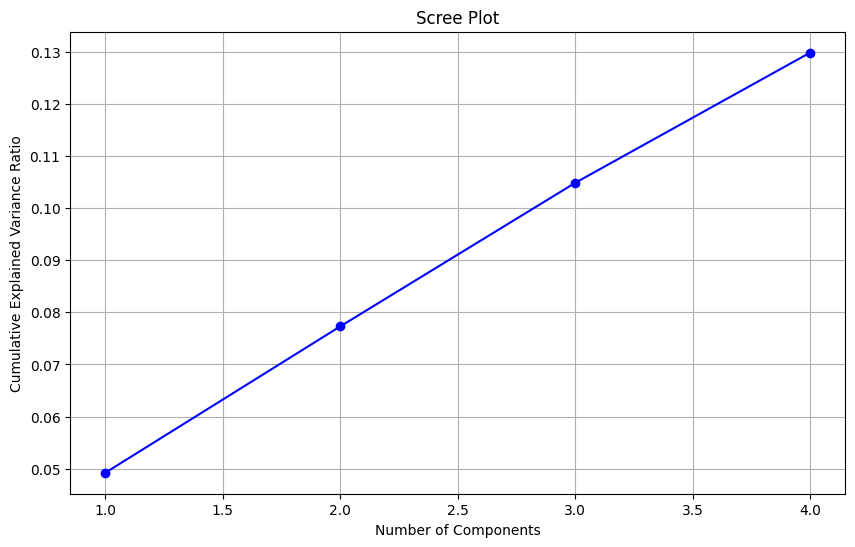

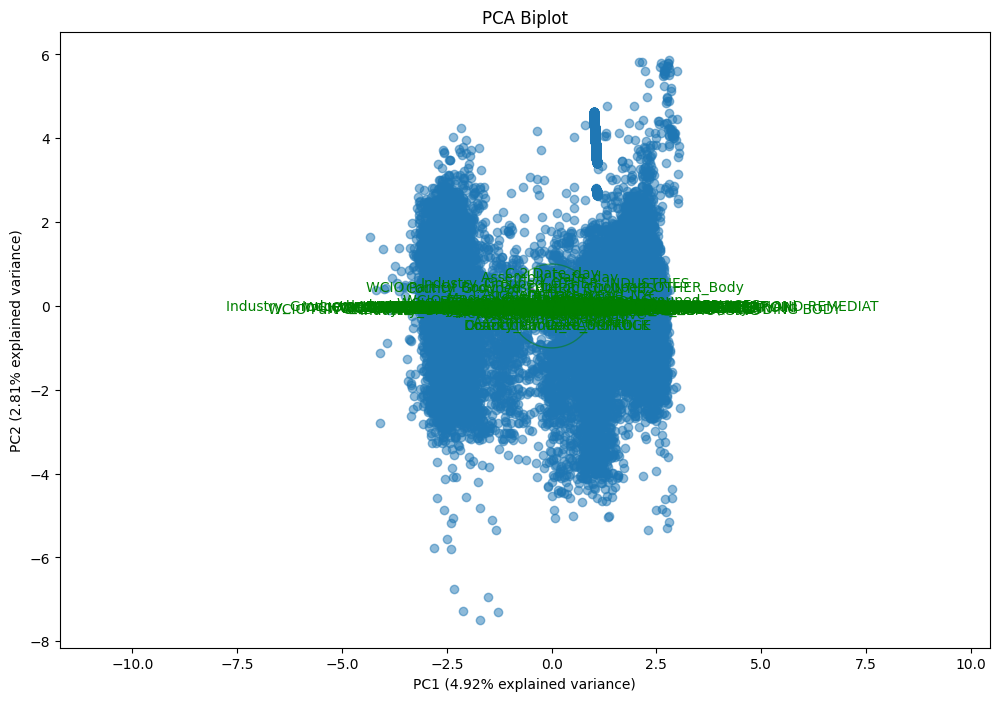

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

def validate_standardization(X, feature_names):
    """
    Validate that the input data is properly standardized
    """
    for feature, column in zip(feature_names, X.T):
        mean = column.mean()
        std = column.std()

        if not (-0.0001 <= mean <= 0.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Mean = {mean:.6f} (should be close to 0)")
        if not (0.9999 <= std <= 1.0001):
            raise ValueError(f"Feature {feature} is not properly standardized. Std = {std:.6f} (should be close to 1)")

    print("Validation complete: All features are properly standardized")
    standardization_summary = pd.DataFrame({
        'Feature': feature_names,
        'Mean': [X[:, i].mean() for i in range(X.shape[1])],
        'Std': [X[:, i].std() for i in range(X.shape[1])]
    })
    print("\nStandardization Summary:")
    print(standardization_summary.round(6))

def perform_pca_analysis(df, target_column, n_components=4):
    """
    Perform PCA analysis on a dataframe, excluding the target column and any non-numeric columns.
    Assumes input data is already standardized.
    """
    # Remove target column and get numeric columns only
    X = df.drop(columns=[target_column])
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[numeric_cols]

    print("\nNumeric columns used for PCA:")
    print(numeric_cols.tolist())

    # Store feature names for later use
    feature_names = X.columns.tolist()

    # Convert to numpy array for validation
    X_array = X.values

    # Validate standardization
    validate_standardization(X_array, feature_names)

    # Apply PCA directly to the already standardized data
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_array)

    # Create DataFrame with principal components
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

    # Print explained variance ratios
    print("\nExplained Variance Ratios:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i+1}: {ratio:.3f} ({ratio*100:.1f}%)")
    print(f"Cumulative: {sum(pca.explained_variance_ratio_):.3f} ({sum(pca.explained_variance_ratio_)*100:.1f}%)")

    return pca_df, pca, feature_names

def plot_pca_results(pca_df, pca, feature_names, save_path=None):
    """
    Create and save PCA visualization plots
    """
    # Create directory if it doesn't exist
    if save_path:
        os.makedirs(save_path, exist_ok=True)

    # Scree plot
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Scree Plot')
    if save_path:
        plt.savefig(f'{save_path}/scree_plot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Biplot
    plt.figure(figsize=(12, 8))
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

    # Plot loadings
    for i, feature in enumerate(feature_names):
        plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
                 color='r', alpha=0.5, head_width=0.05)
        plt.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15,
                feature, color='g', ha='center', va='center')

    # Plot scatter points
    plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} explained variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} explained variance)')
    plt.title('PCA Biplot')

    # Add a circle
    circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='g', alpha=0.5)
    plt.gca().add_patch(circle)
    plt.axis('equal')

    if save_path:
        plt.savefig(f'{save_path}/biplot.svg', format='svg', bbox_inches='tight')
    plt.show()

    # Print component loadings
    print("\nPrincipal Component Loadings:")
    for i in range(pca.n_components_):
        print(f"\nPrincipal Component {i+1}:")
        loadings_dict = dict(zip(feature_names, pca.components_[i]))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        for feature, loading in sorted_loadings:
            print(f"{feature}: {loading:.3f}")

# Run the analysis
pca_df, pca, feature_names = perform_pca_analysis(processed_data, target_column='Claim Injury Type')
plot_pca_results(pca_df, pca, feature_names, save_path='plots')

# Print shape of original data and transformed data
print("\nData Shapes:")
print(f"Original numeric features: {len(feature_names)}")
print(f"Principal components: {pca_df.shape[1]}")


Principal Component Loadings:

Principal Component 1:
District Name_NYC: 0.418
Medical Fee Region_IV: 0.416
Medical Fee Region_I: -0.325
Zip_Region: -0.268
Medical Fee Region_II: -0.224
County_Grouped_OTHER_COUNTIES: -0.217
District Name_ALBANY: -0.192
District Name_BUFFALO: -0.180
District Name_ROCHESTER: -0.174
District Name_SYRACUSE: -0.163
County_Grouped_QUEENS: 0.160
County_Grouped_KINGS: 0.152
County_Grouped_ERIE: -0.147
County_Grouped_Other: -0.139
County_Grouped_BRONX: 0.137
County_Grouped_MONROE: -0.131
District Name_BINGHAMTON: -0.122
County_Grouped_NASSAU: 0.121
County_Grouped_NEW YORK: 0.103
Attorney/Representative: 0.096
County_Grouped_ONONDAGA: -0.094
Industry_Grouped_MANUFACTURING: -0.089
Industry_Grouped_TRANSPORTATION AND WAREHOUSING: 0.082
County_Grouped_RICHMOND: 0.076
County_Grouped_ALBANY: -0.074
District Name_HAUPPAUGE: 0.059
County_Grouped_ORANGE: -0.059
County_Grouped_SUFFOLK: 0.059
Industry_Grouped_EDUCATIONAL SERVICES: -0.056
Accident Date_month: 0.051
County

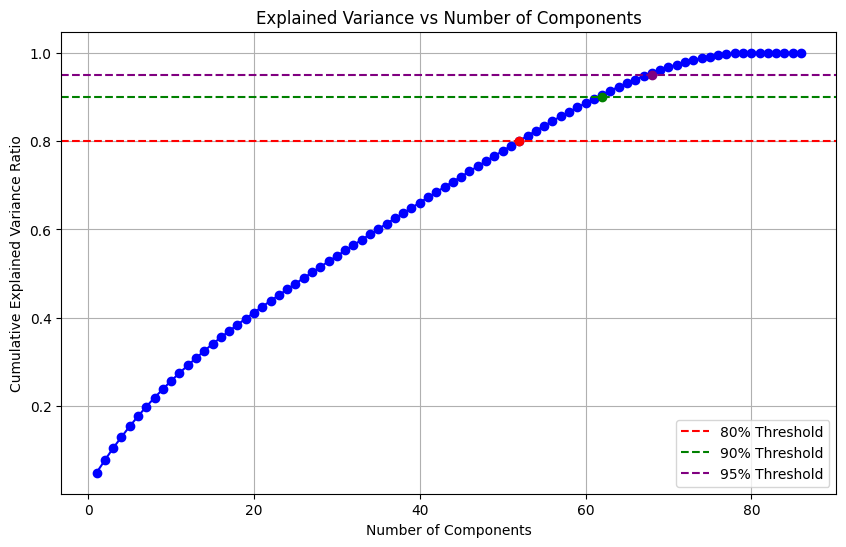

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def analyze_pca_variance(df, target_column):
    # Remove target column and get numeric columns only
    X = df.drop(columns=[target_column])
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[numeric_cols]

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit PCA with maximum possible components
    pca = PCA()
    pca.fit(X_scaled)

    # Plot cumulative explained variance
    plt.figure(figsize=(10, 6))
    cumsum = np.cumsum(pca.explained_variance_ratio_)

    # Plot
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'bo-')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
    plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
    plt.axhline(y=0.95, color='purple', linestyle='--', label='95% Threshold')

    # Add threshold intersect points
    n_components_80 = np.where(cumsum >= 0.8)[0][0] + 1 if len(np.where(cumsum >= 0.8)[0]) > 0 else len(cumsum)
    n_components_90 = np.where(cumsum >= 0.9)[0][0] + 1 if len(np.where(cumsum >= 0.9)[0]) > 0 else len(cumsum)
    n_components_95 = np.where(cumsum >= 0.95)[0][0] + 1 if len(np.where(cumsum >= 0.95)[0]) > 0 else len(cumsum)

    plt.plot(n_components_80, 0.8, 'ro')
    plt.plot(n_components_90, 0.9, 'go')
    plt.plot(n_components_95, 0.95, 'purple', marker='o')

    plt.grid(True)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance vs Number of Components')
    plt.legend()

    # Print variance information
    print("\nExplained Variance Analysis:")
    for i, ratio in enumerate(pca.explained_variance_ratio_[:10], 1):
        print(f"PC{i}: {ratio:.3f} ({ratio*100:.1f}%)")

    print(f"\nComponents needed for:")
    print(f"80% variance: {n_components_80}")
    print(f"90% variance: {n_components_90}")
    print(f"95% variance: {n_components_95}")

    plt.show()

    return pca

# Run the analysis
pca = analyze_pca_variance(processed_data, 'Claim Injury Type')

In [20]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

def create_pca_report(df, target_column, n_components=68):
    """
    Creates a comprehensive PCA report with 68 components.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    target_column (str): Target column to exclude
    n_components (int): Number of principal components (default 68)

    Returns:
    tuple: (PCA object, loadings DataFrame, summary DataFrame)
    """
    # Remove target column and get numeric columns only
    X = df.drop(columns=[target_column])
    numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
    X = X[numeric_cols]

    # Fit PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X)

    # Create loadings DataFrame
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(n_components)],
        index=numeric_cols
    )

    # Calculate explained variance summary
    explained_variance = pd.DataFrame({
        'Component': [f'PC{i+1}' for i in range(n_components)],
        'Individual Variance (%)': [f'{var:.2f}%' for var in pca.explained_variance_ratio_ * 100],
        'Cumulative Variance (%)': [f'{var:.2f}%' for var in np.cumsum(pca.explained_variance_ratio_) * 100]
    })

    # Format loadings for each component
    component_interpretations = []
    for i in range(n_components):
        pc_loadings = loadings[f'PC{i+1}'].sort_values(ascending=False)

        # Get top 5 positive and negative contributors with threshold
        top_pos = pc_loadings[pc_loadings > 0.1][:5]
        top_neg = pc_loadings[pc_loadings < -0.1][-5:]

        interpretation = {
            'PC': f'PC{i+1}',
            'Var%': f'{pca.explained_variance_ratio_[i]:.2%}',
            'Cum%': f'{np.sum(pca.explained_variance_ratio_[:i+1]):.2%}',
            'Top Positive': ' | '.join([f"{idx.split('_')[0]}:{val:.3f}" for idx, val in top_pos.items()]),
            'Top Negative': ' | '.join([f"{idx.split('_')[0]}:{val:.3f}" for idx, val in top_neg.items()])
        }
        component_interpretations.append(interpretation)

    # Create summary DataFrame
    summary_df = pd.DataFrame(component_interpretations)

    # Print formatted report
    print("\nPCA ANALYSIS REPORT")
    print("=" * 120)

    print("\n1. VARIANCE SUMMARY")
    print("-" * 120)
    # Find components needed for different variance thresholds
    var_cumsum = np.cumsum(pca.explained_variance_ratio_)
    thresholds = [0.5, 0.75, 0.9, 0.95, 0.99]
    print("Components needed for variance explained:")
    for threshold in thresholds:
        n_comp = np.argmax(var_cumsum >= threshold) + 1
        print(f"{threshold*100:>3.0f}% variance: {n_comp:>3} components")

    print("\n2. COMPONENT BREAKDOWN")
    print("-" * 120)
    # Print components in groups of 10
    for i in range(0, n_components, 10):
        end_idx = min(i + 10, n_components)
        print(f"\nComponents {i+1}-{end_idx}")
        print(summary_df.iloc[i:end_idx].to_string(index=False))

    print("\n3. SIGNIFICANT LOADINGS")
    print("-" * 120)
    # Print significant loadings (abs > 0.3) for each component
    for i in range(n_components):
        pc_loadings = loadings[f'PC{i+1}']
        significant = pc_loadings[abs(pc_loadings) > 0.3].sort_values(ascending=False)
        if not significant.empty:
            print(f"\nPC{i+1} (Var: {pca.explained_variance_ratio_[i]:.2%}):")
            for idx, val in significant.items():
                print(f"  {idx}: {val:.3f}")

    return pca, loadings, summary_df

# Run the analysis
pca, loadings, summary = create_pca_report(processed_data, 'Claim Injury Type')

# Save the loadings to a CSV file for further analysis
loadings.to_csv('pca_loadings.csv')
summary.to_csv('pca_summary.csv')


PCA ANALYSIS REPORT

1. VARIANCE SUMMARY
------------------------------------------------------------------------------------------------------------------------
Components needed for variance explained:
 50% variance:  27 components
 75% variance:  48 components
 90% variance:  62 components
 95% variance:  68 components
 99% variance:   1 components

2. COMPONENT BREAKDOWN
------------------------------------------------------------------------------------------------------------------------

Components 1-10
  PC  Var%   Cum%                                                                                                             Top Positive                                                                                                                     Top Negative
 PC1 4.92%  4.92%                              District Name:0.418 | Medical Fee Region:0.416 | County:0.160 | County:0.152 | County:0.137                        District Name:-0.192 | County:-0.217 | Medical Fee Re

In [21]:
df_dropped.to_csv('test.csv', index=False)

NameError: name 'df_dropped' is not defined

In [22]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.2 MB/s eta 0:00:00



Analyzing geographic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[2.84664384e-13 2.14495605e-07 1.18217101e-07 7.33846938e-06]
not reaching the requested tolerance 6.556510925292969e-07.
Use iteration 646 instead with accuracy 
1.0803754681586821e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[7.68833025e-14 2.21176642e-07 1.19808978e-07 3.98051595e-06]
not reaching the requested tolerance 6.556510925292969e-07.
  _, diffusion_map = lobpcg(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


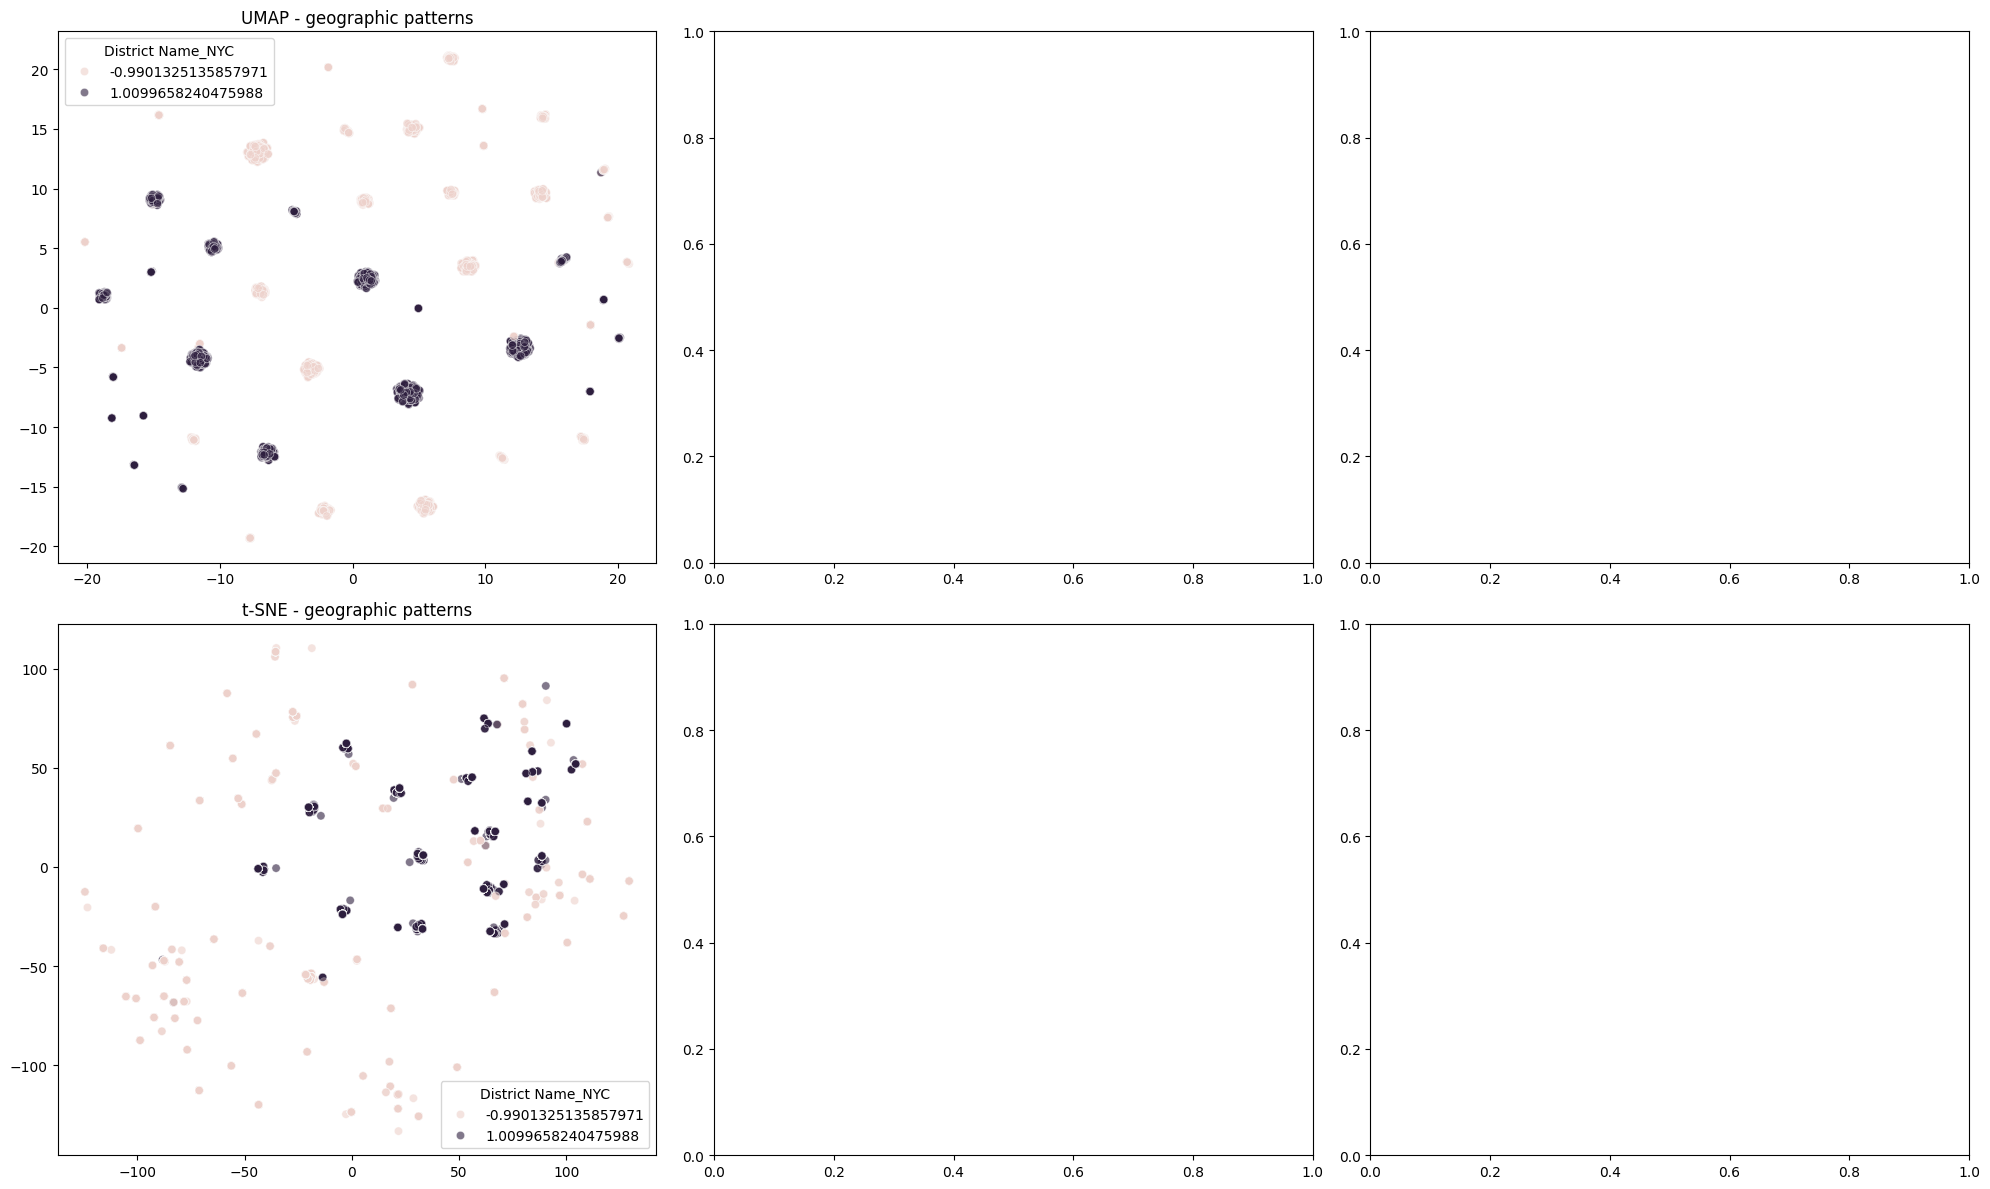


Analyzing temporal features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


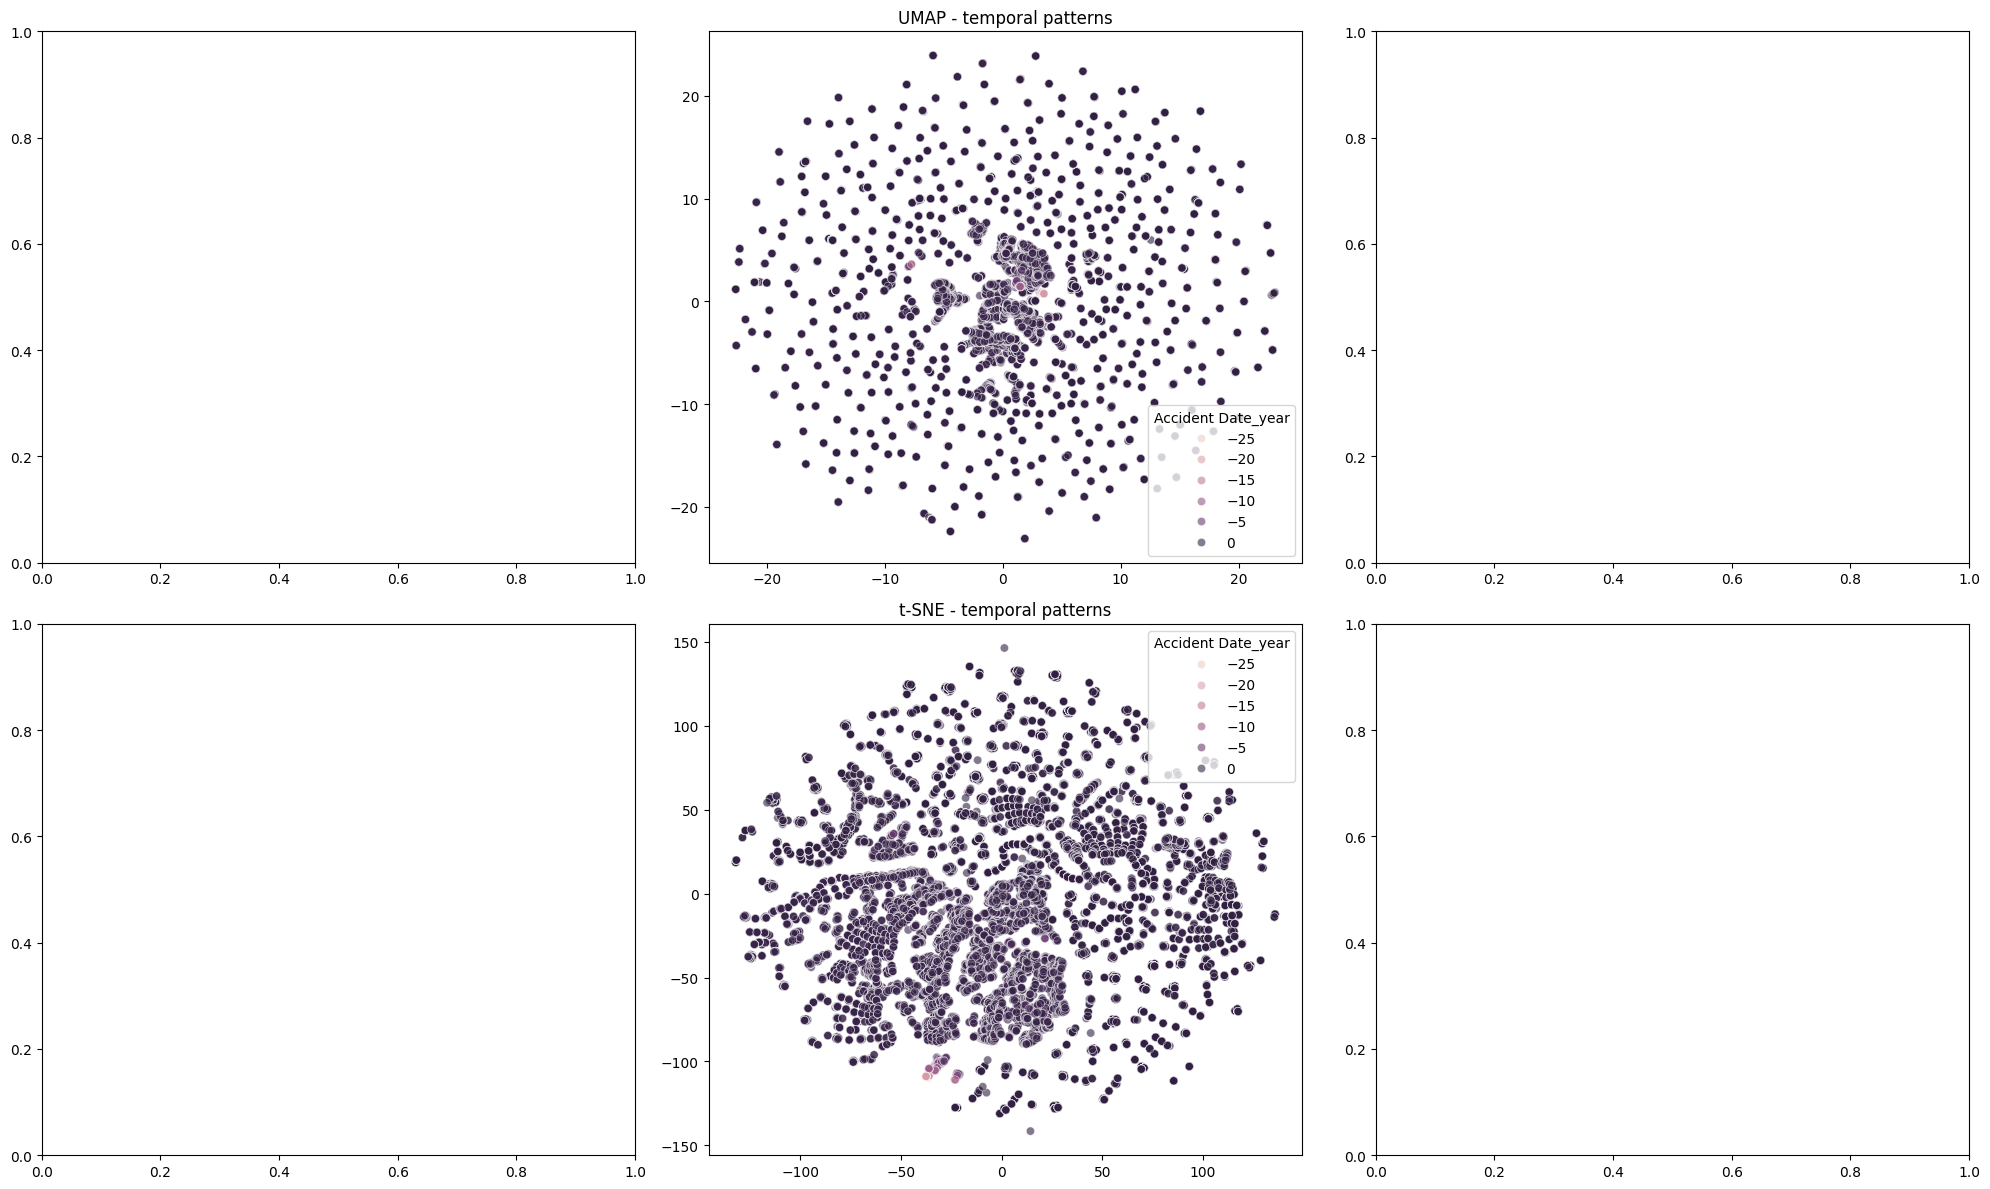


Analyzing case_specific features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 96 with accuracies 
[3.06652291e-15 2.32280187e-06 1.05934848e-05 3.59881140e-06]
not reaching the requested tolerance 4.738569259643555e-06.
Use iteration 96 instead with accuracy 
4.128774515546944e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.94993552e-15 2.32280177e-06 1.05934849e-05 3.59881118e-06]
not reaching the requested tolerance 4.738569259643555e-06.
  _, diffusion_map = lobpcg(


Running t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


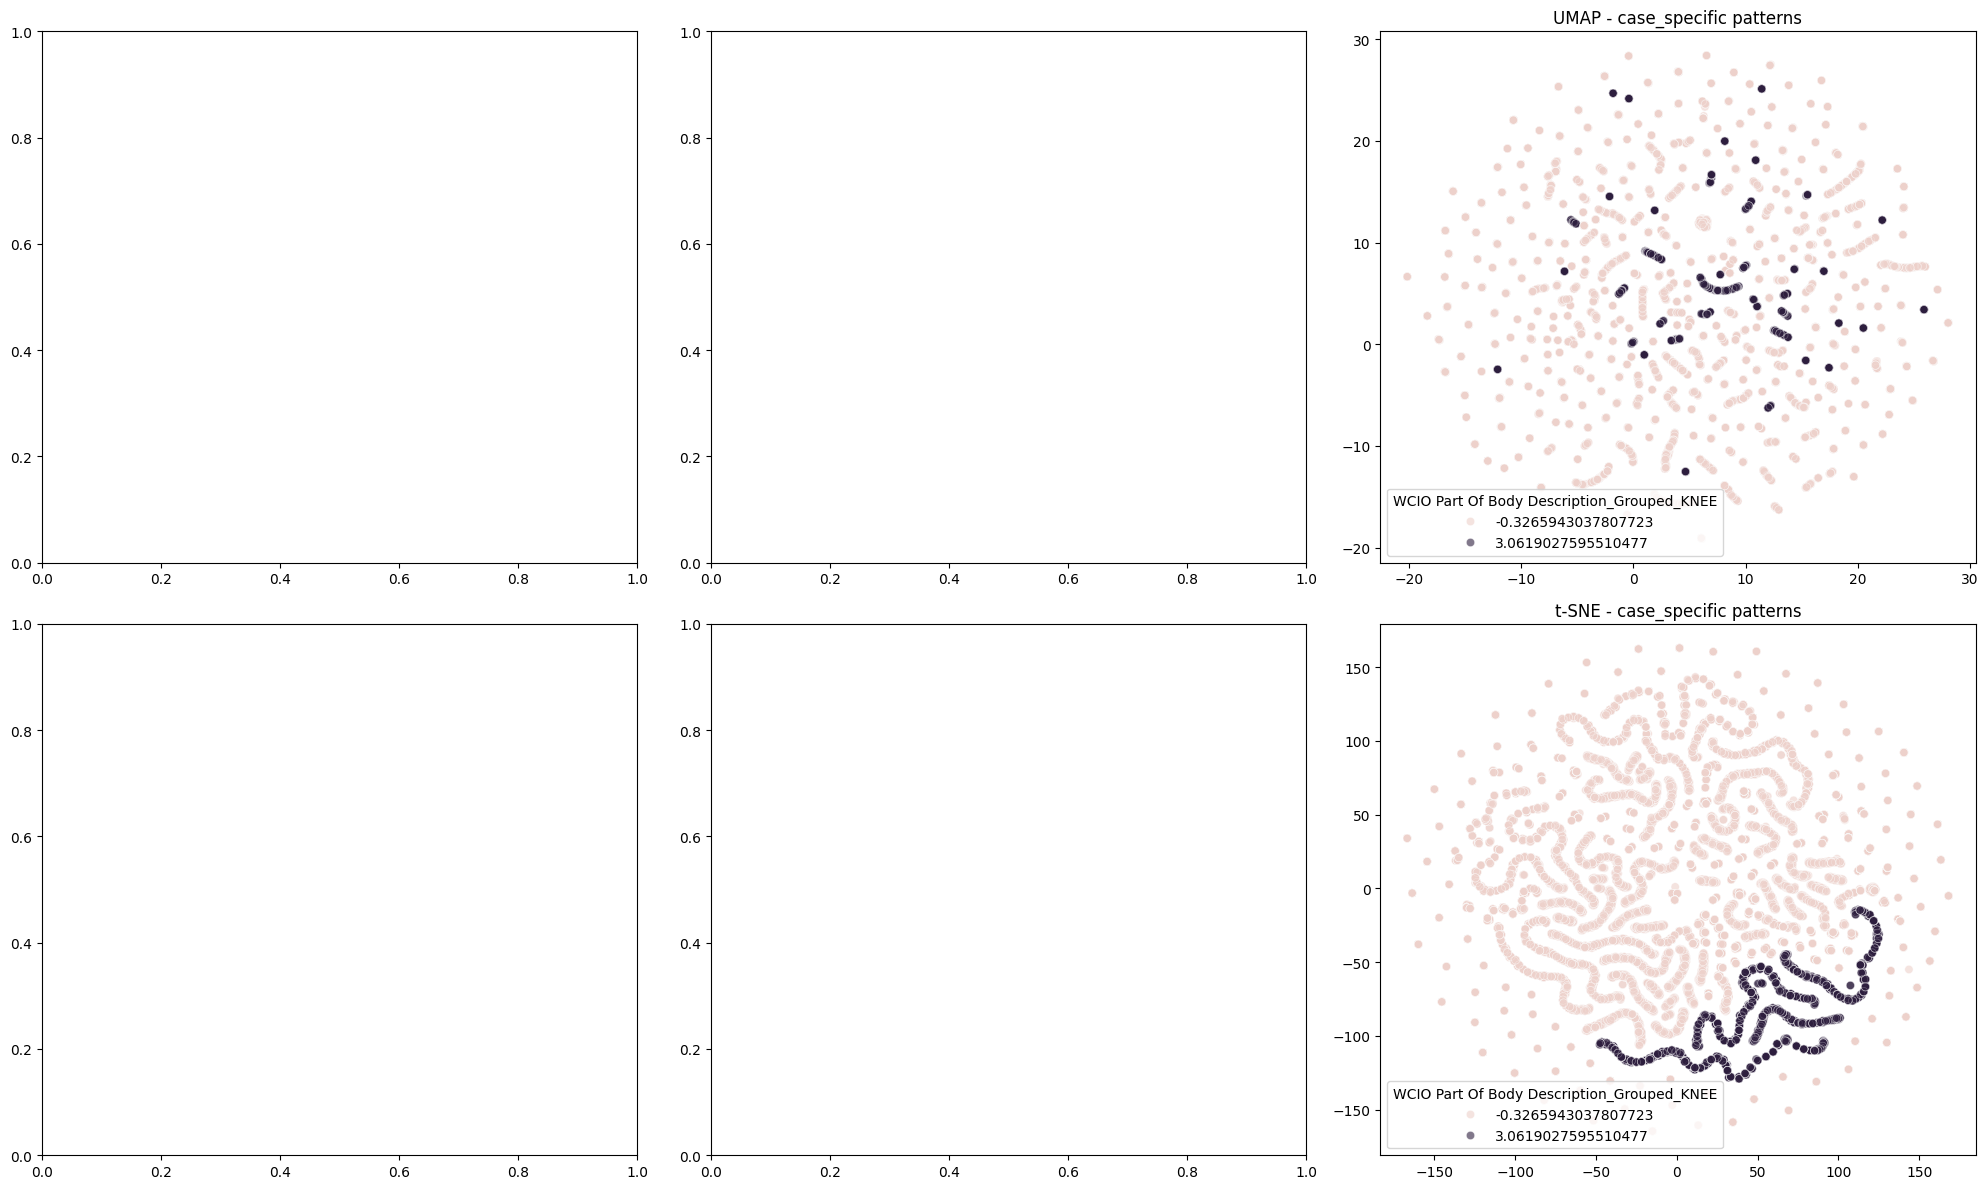

In [23]:
import umap
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Define feature groups based on PCA insights
feature_groups = {
    'geographic': [
        'District Name_ALBANY', 'District Name_BINGHAMTON', 'District Name_BUFFALO',
        'District Name_HAUPPAUGE', 'District Name_NYC', 'District Name_ROCHESTER',
        'District Name_SYRACUSE',
        'Medical Fee Region_I', 'Medical Fee Region_II', 'Medical Fee Region_III',
        'Medical Fee Region_IV',
        'County_Grouped_ALBANY', 'County_Grouped_BRONX', 'County_Grouped_ERIE',
        'County_Grouped_KINGS', 'County_Grouped_MONROE', 'County_Grouped_NASSAU',
        'County_Grouped_NEW YORK', 'County_Grouped_ONONDAGA', 'County_Grouped_QUEENS',
        'County_Grouped_RICHMOND', 'County_Grouped_SUFFOLK', 'County_Grouped_WESTCHESTER'
    ],
    'temporal': [
        'C-2 Date_year', 'C-2 Date_month', 'C-2 Date_day',
        'Assembly Date_year', 'Assembly Date_month', 'Assembly Date_day',
        'Accident Date_year', 'Accident Date_month', 'Accident Date_day'
    ],
    'case_specific': [
        'WCIO Part Of Body Description_Grouped_ABDOMEN INCLUDING GROIN',
        'WCIO Part Of Body Description_Grouped_ANKLE',
        'WCIO Part Of Body Description_Grouped_BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
        'WCIO Part Of Body Description_Grouped_CHEST',
        'WCIO Part Of Body Description_Grouped_ELBOW',
        'WCIO Part Of Body Description_Grouped_EYE(S)',
        'WCIO Part Of Body Description_Grouped_FINGER(S)',
        'WCIO Part Of Body Description_Grouped_FOOT',
        'WCIO Part Of Body Description_Grouped_HAND',
        'WCIO Part Of Body Description_Grouped_HIP',
        'WCIO Part Of Body Description_Grouped_KNEE',
        'WCIO Part Of Body Description_Grouped_LOWER ARM',
        'WCIO Part Of Body Description_Grouped_LOWER BACK AREA',
        'WCIO Part Of Body Description_Grouped_LOWER LEG',
        'WCIO Part Of Body Description_Grouped_LUNGS',
        'COVID-19 Indicator',
        'Gender_Clean',
        'Age at Injury',
        'Attorney/Representative'
    ]
}

def visualize_patterns(df, feature_groups, title_prefix=''):
    """
    Visualize different feature group patterns with both UMAP and t-SNE
    """
    # UMAP parameters for better global structure
    umap_params = {
        'n_neighbors': 15,     # local neighborhood size
        'min_dist': 0.1,       # minimum spacing
        'n_components': 2,     # 2D visualization
        'random_state': 42
    }

    # t-SNE parameters for local structure
    tsne_params = {
        'n_components': 2,
        'perplexity': 30,      # balance local vs global
        'n_iter': 1000,
        'random_state': 42
    }

    # Create subplots for each method
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Color schemes for different aspects
    color_schemes = {
        'geographic': df['District Name_NYC'] if 'District Name_NYC' in df.columns else None,
        'temporal': df['Accident Date_year'] if 'Accident Date_year' in df.columns else None,
        'case_specific': df['WCIO Part Of Body Description_Grouped_KNEE'] if 'WCIO Part Of Body Description_Grouped_KNEE' in df.columns else None
    }

    # Run UMAP and t-SNE
    print("Running UMAP...")
    umap_embed = umap.UMAP(**umap_params).fit_transform(df)
    print("Running t-SNE...")
    tsne_embed = TSNE(**tsne_params).fit_transform(df)

    # Plot each color scheme
    for idx, (aspect, colors) in enumerate(color_schemes.items()):
        if colors is not None:
            # UMAP plot
            sns.scatterplot(
                x=umap_embed[:, 0],
                y=umap_embed[:, 1],
                hue=colors,
                alpha=0.6,
                ax=axes[0, idx]
            )
            axes[0, idx].set_title(f'UMAP - {aspect} patterns')

            # t-SNE plot
            sns.scatterplot(
                x=tsne_embed[:, 0],
                y=tsne_embed[:, 1],
                hue=colors,
                alpha=0.6,
                ax=axes[1, idx]
            )
            axes[1, idx].set_title(f't-SNE - {aspect} patterns')

    plt.tight_layout()
    plt.show()

    return umap_embed, tsne_embed

# Assuming your processed data is in 'processed_data'
# Compare different feature subsets
for group_name, features in feature_groups.items():
    print(f"\nAnalyzing {group_name} features...")
    # Filter only the features that exist in the dataframe
    available_features = [f for f in features if f in processed_data.columns]
    if available_features:
        subset_df = processed_data[available_features]
        umap_result, tsne_result = visualize_patterns(
            subset_df,
            feature_groups,
            title_prefix=group_name
        )
    else:
        print(f"No features found for {group_name}")

In [24]:
# Should see distinct clusters for:
geographic_validation = {
    'NYC_cluster': 'Clear separation of NYC districts',
    'regional_groups': 'Upstate vs Downstate separation',
    'fee_regions': 'Medical fee region boundaries'
}

# Look for:
temporal_validation = {
    'yearly_progression': 'Gradual color transitions',
    'covid_impact': 'Clear pre/post COVID separation',
    'seasonal_cycles': 'Circular or spiral patterns'
}

# Expect to see:
case_validation = {
    'injury_groups': 'Clusters of similar injuries',
    'severity_gradients': 'Smooth transitions between related injuries',
    'outlier_cases': 'Isolated points for unusual combinations'
}



In [25]:
def compare_embeddings_with_pca(pca_results, umap_embed, tsne_embed, df):
    """
    Compare clustering patterns across methods
    """
    # Calculate silhouette scores for each method
    clustering_comparison = pd.DataFrame({
        'Method': ['PCA', 'UMAP', 't-SNE'],
        'Geographic_Separation': [
            silhouette_score(pca_results, df['District_Name']),
            silhouette_score(umap_embed, df['District_Name']),
            silhouette_score(tsne_embed, df['District_Name'])
        ],
        'Temporal_Separation': [
            # Similar for temporal features
        ],
        'Case_Separation': [
            # Similar for case features
        ]
    })
    return clustering_comparison

Performing UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Performing t-SNE...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


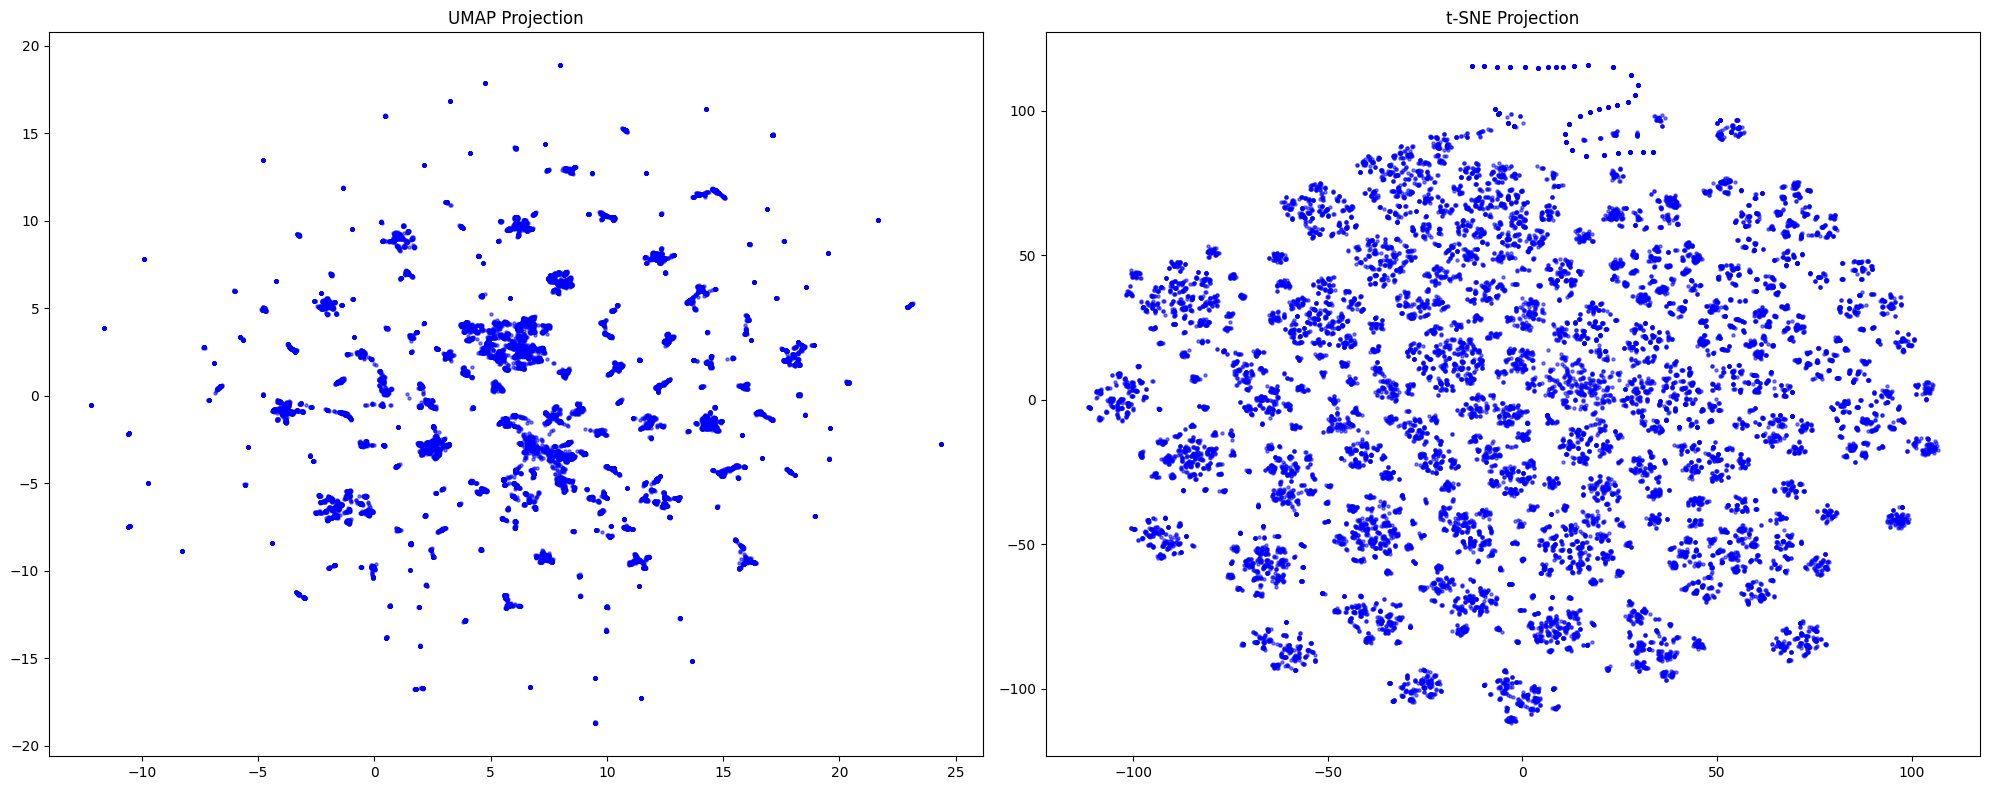

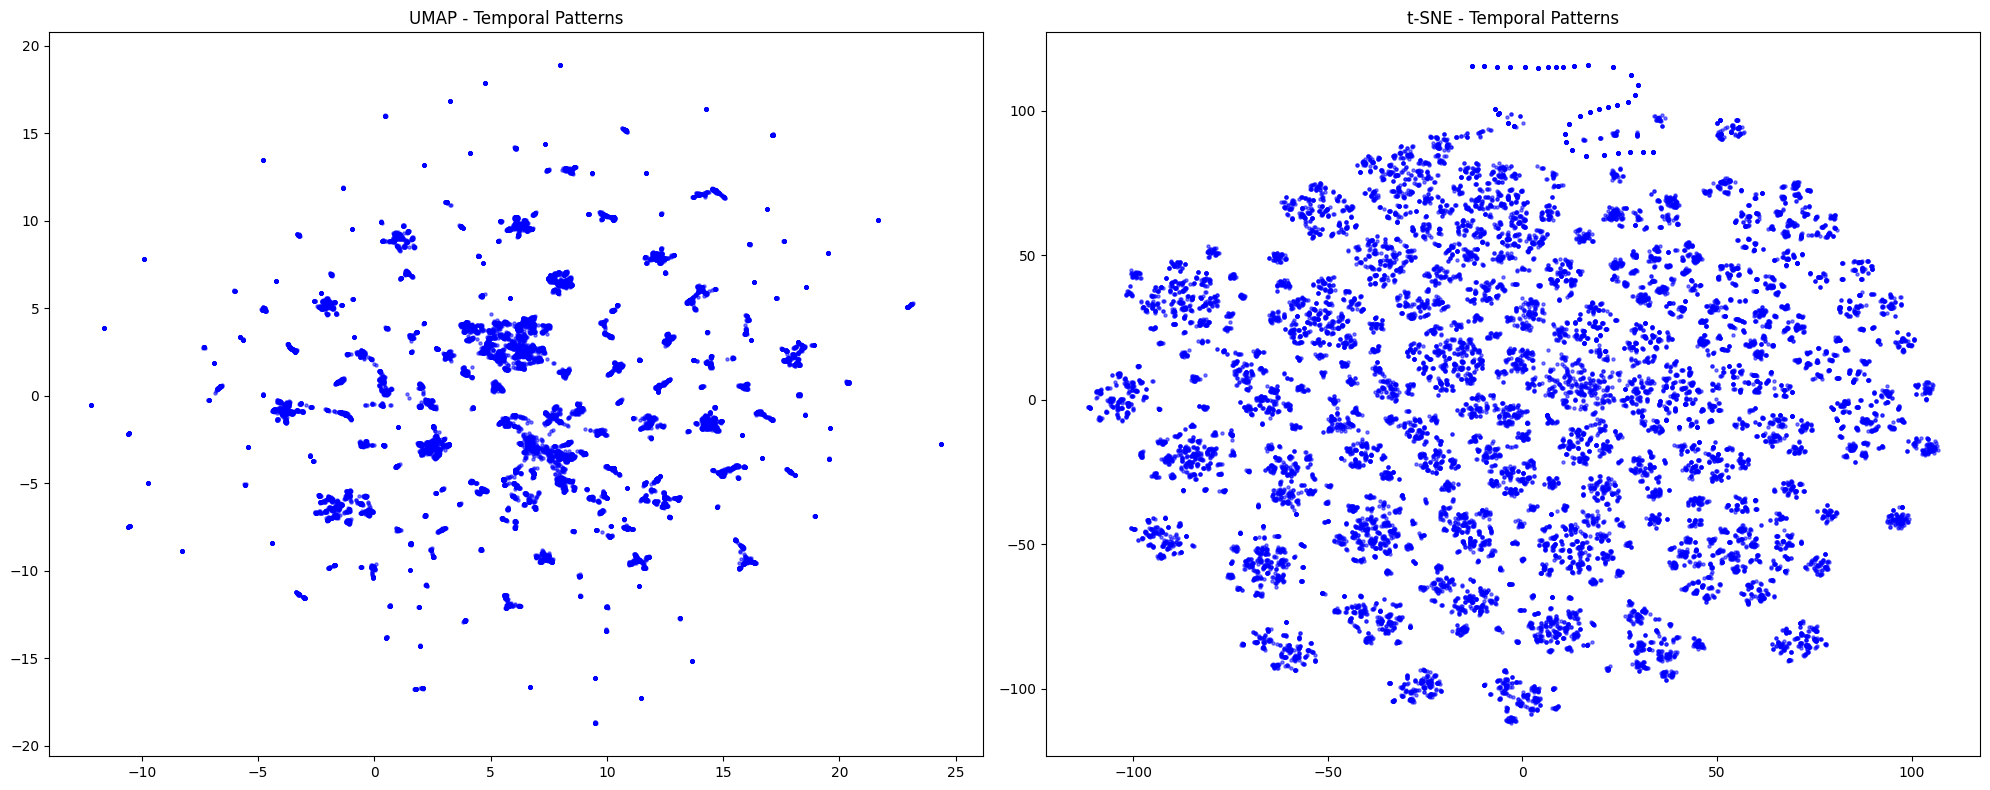

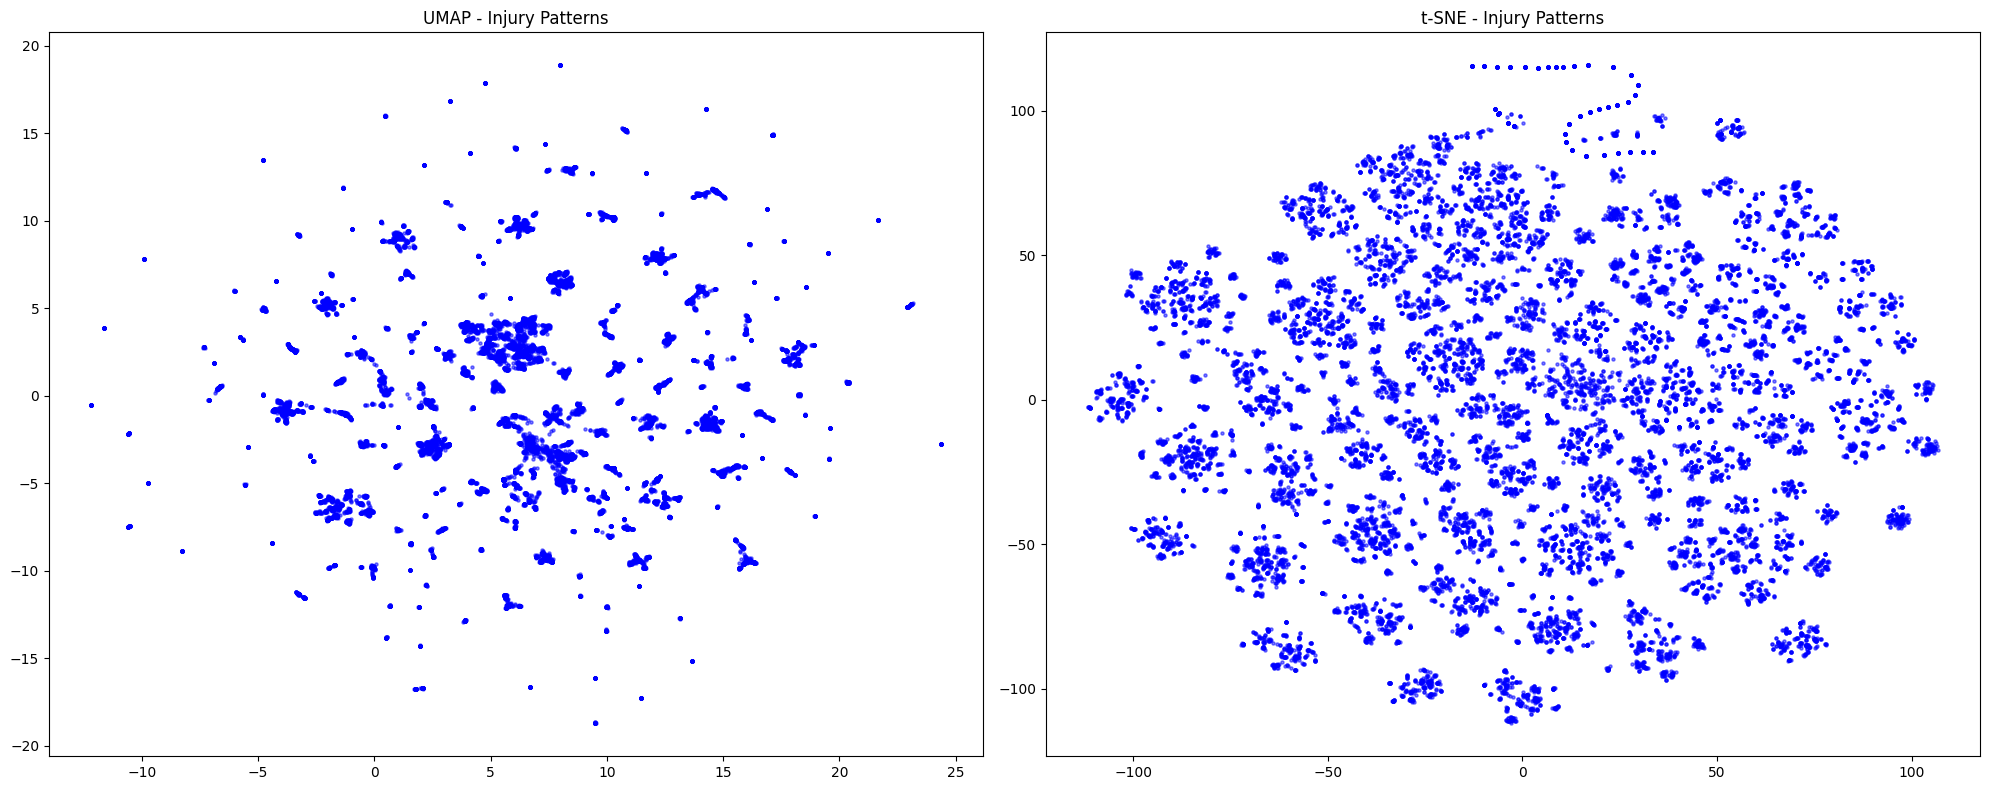

In [26]:
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Assuming your preprocessed data is in 'processed_data'
# and categorical columns are already encoded

def create_visualizations(df, target_column='Claim Injury Type'):
    # Remove target and standardize
    X = df.drop(columns=[target_column])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # UMAP
    print("Performing UMAP...")
    umap_2d = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric='euclidean',
        random_state=42
    )
    umap_result = umap_2d.fit_transform(X_scaled)

    # t-SNE
    print("Performing t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        n_iter=1000,
        random_state=42
    )
    tsne_result = tsne.fit_transform(X_scaled)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by District (geographic pattern)
    district_colors = df['District Name'] if 'District Name' in df.columns else None

    # UMAP plot
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP Projection')
    if district_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='District')

    # t-SNE plot
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=district_colors.astype('category').cat.codes if district_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE Projection')
    if district_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='District')

    plt.tight_layout()
    plt.show()

    # Additional visualizations for temporal patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by time (if available)
    time_colors = pd.to_datetime(df['Accident Date']).dt.year if 'Accident Date' in df.columns else None

    # UMAP plot - temporal
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Year')

    # t-SNE plot - temporal
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=time_colors if time_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Temporal Patterns')
    if time_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Year')

    plt.tight_layout()
    plt.show()

    # Visualization for injury patterns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Color by injury type
    injury_colors = df['WCIO Part Of Body Description'] if 'WCIO Part Of Body Description' in df.columns else None

    # UMAP plot - injury
    scatter1 = ax1.scatter(
        umap_result[:, 0],
        umap_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax1.set_title('UMAP - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter1, ax=ax1, label='Body Part')

    # t-SNE plot - injury
    scatter2 = ax2.scatter(
        tsne_result[:, 0],
        tsne_result[:, 1],
        c=injury_colors.astype('category').cat.codes if injury_colors is not None else 'blue',
        alpha=0.5,
        s=5
    )
    ax2.set_title('t-SNE - Injury Patterns')
    if injury_colors is not None:
        plt.colorbar(scatter2, ax=ax2, label='Body Part')

    plt.tight_layout()
    plt.show()

    return umap_result, tsne_result

# Execute
umap_result, tsne_result = create_visualizations(processed_data)

# Optional: Save results
np.save('umap_embedding.npy', umap_result)
np.save('tsne_embedding.npy', tsne_result)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import umap
from sklearn.manifold import TSNE

def run_dimensionality_reduction(data, feature_groups):
    """
    Run UMAP and t-SNE for each feature group and store results
    """
    umap_results = {}
    tsne_results = {}

    # UMAP parameters
    umap_params = {
        'n_neighbors': 15,
        'min_dist': 0.1,
        'n_components': 2,
        'random_state': 42
    }

    # t-SNE parameters
    tsne_params = {
        'n_components': 2,
        'perplexity': 30,
        'max_iter': 1000,
        'random_state': 42
    }

    for group_name, features in feature_groups.items():
        print(f"\nProcessing {group_name} features...")

        # Get available features
        available_features = [f for f in features if f in data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = data[available_features]

        # Run UMAP
        print("Running UMAP...")
        umap_results[group_name] = umap.UMAP(**umap_params).fit_transform(subset_data)

        # Run t-SNE
        print("Running t-SNE...")
        tsne_results[group_name] = TSNE(**tsne_params).fit_transform(subset_data)

    return umap_results, tsne_results

def analyze_embeddings(embeddings, labels, group_name, original_data):
    """
    Comprehensive analysis of embedding quality and cluster separation
    """
    results = {}

    # Clustering Quality Metrics
    try:
        results['silhouette'] = silhouette_score(embeddings, labels)
        results['calinski'] = calinski_harabasz_score(embeddings, labels)
        results['davies'] = davies_bouldin_score(embeddings, labels)
    except Exception as e:
        print(f"Warning: Clustering metrics failed for {group_name}: {str(e)}")
        results['silhouette'] = np.nan
        results['calinski'] = np.nan
        results['davies'] = np.nan

    # Distribution Analysis
    feature_stats = {
        'mean': np.mean(embeddings, axis=0),
        'std': np.std(embeddings, axis=0),
        'skew': pd.DataFrame(embeddings).skew().values,
        'kurtosis': pd.DataFrame(embeddings).kurtosis().values
    }
    results['distribution'] = feature_stats

    return results

def generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups):
    """
    Generate comprehensive analysis report
    """
    print("\n" + "="*50)
    print("EMBEDDING ANALYSIS REPORT")
    print("="*50)

    for group_name, features in feature_groups.items():
        print(f"\n{group_name.upper()} ANALYSIS:")
        print("-"*30)

        # Get relevant data
        available_features = [f for f in features if f in processed_data.columns]
        if not available_features:
            print(f"No features found for {group_name}")
            continue

        subset_data = processed_data[available_features]

        # Get primary label for this group
        primary_label = available_features[0]
        labels = processed_data[primary_label]

        if group_name in umap_results and group_name in tsne_results:
            # Analyze UMAP results
            umap_analysis = analyze_embeddings(
                umap_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Analyze t-SNE results
            tsne_analysis = analyze_embeddings(
                tsne_results[group_name],
                labels,
                group_name,
                subset_data
            )

            # Print Results
            print("\nUMAP Analysis:")
            print(f"Silhouette Score: {umap_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {umap_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {umap_analysis['davies']:.3f}")

            print("\nt-SNE Analysis:")
            print(f"Silhouette Score: {tsne_analysis['silhouette']:.3f}")
            print(f"Calinski-Harabasz Score: {tsne_analysis['calinski']:.3f}")
            print(f"Davies-Bouldin Score: {tsne_analysis['davies']:.3f}")

        # Feature Importance Analysis
        print("\nFeature Importance Analysis:")
        feature_importance = analyze_feature_importance(subset_data)
        print(feature_importance.to_string())

        # Distribution Analysis
        print("\nDistribution Characteristics:")
        plot_distribution_analysis(subset_data, group_name)

# Run the complete analysis
# First, run dimensionality reduction
umap_results, tsne_results = run_dimensionality_reduction(processed_data, feature_groups)

# Then generate the report
generate_analysis_report(processed_data, umap_results, tsne_results, feature_groups)

# Additional Stability Analysis
print("\nCLUSTER STABILITY ANALYSIS")
print("="*30)
for group_name in feature_groups:
    if group_name in umap_results:
        stability = cluster_stability_analysis(
            umap_results[group_name],
            processed_data[feature_groups[group_name][0]]
        )
        print(f"\n{group_name} Stability:")
        print(f"Mean Score: {stability['mean']:.3f} ± {stability['std']:.3f}")
        print(f"95% CI: [{stability['ci_lower']:.3f}, {stability['ci_upper']:.3f}]")


Processing geographic features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 2000 with accuracies 
[2.84664384e-13 2.14495605e-07 1.18217101e-07 7.33846938e-06]
not reaching the requested tolerance 6.556510925292969e-07.
Use iteration 646 instead with accuracy 
1.0803754681586821e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[7.68833025e-14 2.21176642e-07 1.19808978e-07 3.98051595e-06]
not reaching the requested tolerance 6.556510925292969e-07.
  _, diffusion_map = lobpcg(


Running t-SNE...

Processing temporal features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running t-SNE...

Processing case_specific features...
Running UMAP...


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited at iteration 96 with accuracies 
[3.06652291e-15 2.32280187e-06 1.05934848e-05 3.59881140e-06]
not reaching the requested tolerance 4.738569259643555e-06.
Use iteration 96 instead with accuracy 
4.128774515546944e-06.

  _, diffusion_map = lobpcg(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:455: UserWarning: Exited postprocessing with accuracies 
[1.94993552e-15 2.32280177e-06 1.05934849e-05 3.59881118e-06]
not reaching the requested tolerance 4.738569259643555e-06.
  _, diffusion_map = lobpcg(


Running t-SNE...

EMBEDDING ANALYSIS REPORT

GEOGRAPHIC ANALYSIS:
------------------------------

UMAP Analysis:
Silhouette Score: 0.101
Calinski-Harabasz Score: 580.239
Davies-Bouldin Score: 3.759

t-SNE Analysis:
Silhouette Score: 0.162
Calinski-Harabasz Score: 1587.610
Davies-Bouldin Score: 2.232

Feature Importance Analysis:
                            variance  entropy
County_Grouped_RICHMOND     1.000048      0.0
Medical Fee Region_III      1.000048      0.0
County_Grouped_QUEENS       1.000048      0.0
District Name_NYC           1.000048      0.0
District Name_SYRACUSE      1.000048      0.0
County_Grouped_ALBANY       1.000048      0.0
District Name_HAUPPAUGE     1.000048      0.0
County_Grouped_NASSAU       1.000048      0.0
Medical Fee Region_IV       1.000048      0.0
County_Grouped_SUFFOLK      1.000048      0.0
County_Grouped_KINGS        1.000048      0.0
County_Grouped_MONROE       1.000048      0.0
District Name_BINGHAMTON    1.000048      0.0
Medical Fee Region_I     